In [36]:
from config import numeric_cols,category_cols,target_col
import pandas as pd
import seaborn as sns
from scipy import stats 
import xgboost as xgb
import catboost as cat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from utils.xgb import XGBoostOptimizer
from utils.cat import CatBoostOptimizer
from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.ensemble import VotingClassifier,StackingClassifier

plt.style.use('fivethirtyeight')

* 數據包含10個數字屬性和8個分類屬性
* 'Revenue' 屬性將作為標籤 1 代表會訂房 0 代表不會
* 使用訓練資料 train.csv 建立模型，預測 test.csv 是否會訂房
* 屬性說明：
	- Administrative：管理頁面瀏覽數量
	- Administrative_Duration：管理頁面瀏覽時間
	- Informational：資訊頁面瀏覽數量
	- Informational_Duration：資訊頁面瀏覽時間
	- ProductRelated：產品頁面瀏覽數量
	- ProductRelated_Duration：產品頁面瀏覽時間
	- BounceRates：跳出率
	- ExitRates：退出率
	- PageValues：頁面價值
	- SpecialDay：特殊日期（例如聖誕節，情人節）接近程度
	- Month：訪問月份
	- OperatingSystems：作業系統
	- Browser：瀏覽器
	- Region：地區
	- TrafficType：流量來源
	- VisitorType：訪客類型
	- Weekend：訪問時間是否為週末
	- Revenue：是否訂房


In [2]:
data = pd.read_csv("./data/train.csv")
test  = pd.read_csv("./data/test.csv")

for c in numeric_cols:
    data[c] = data[c].astype('float32')
    test[c] = test[c].astype('float32')
for c in category_cols:
    data[c] = data[c].astype('category')
    test[c] = test[c].astype('category')
data[target_col] = data[target_col].astype('category')
print(data.describe())

                ID  Administrative  Administrative_Duration  Informational  \
count  8100.000000     8100.000000              8100.000000    8100.000000   
mean   4500.375432        2.309876                80.926109       0.498025   
std    2601.276244        3.311618               180.089691       1.258088   
min       0.000000        0.000000                 0.000000       0.000000   
25%    2237.750000        0.000000                 0.000000       0.000000   
50%    4504.500000        1.000000                 7.000000       0.000000   
75%    6760.250000        4.000000                91.988636       0.000000   
max    8999.000000       27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             8100.000000     8100.000000             8.099000e+03   
mean                32.884300       31.787161             8.311547e+04   
std                135.210892       44.961094             6.359096e+06   
m

BounceRates　: 跳出率不應該為負值,這邊當作缺失值處理

In [3]:
data.loc[data['BounceRates']< 0, 'BounceRates'] = np.nan

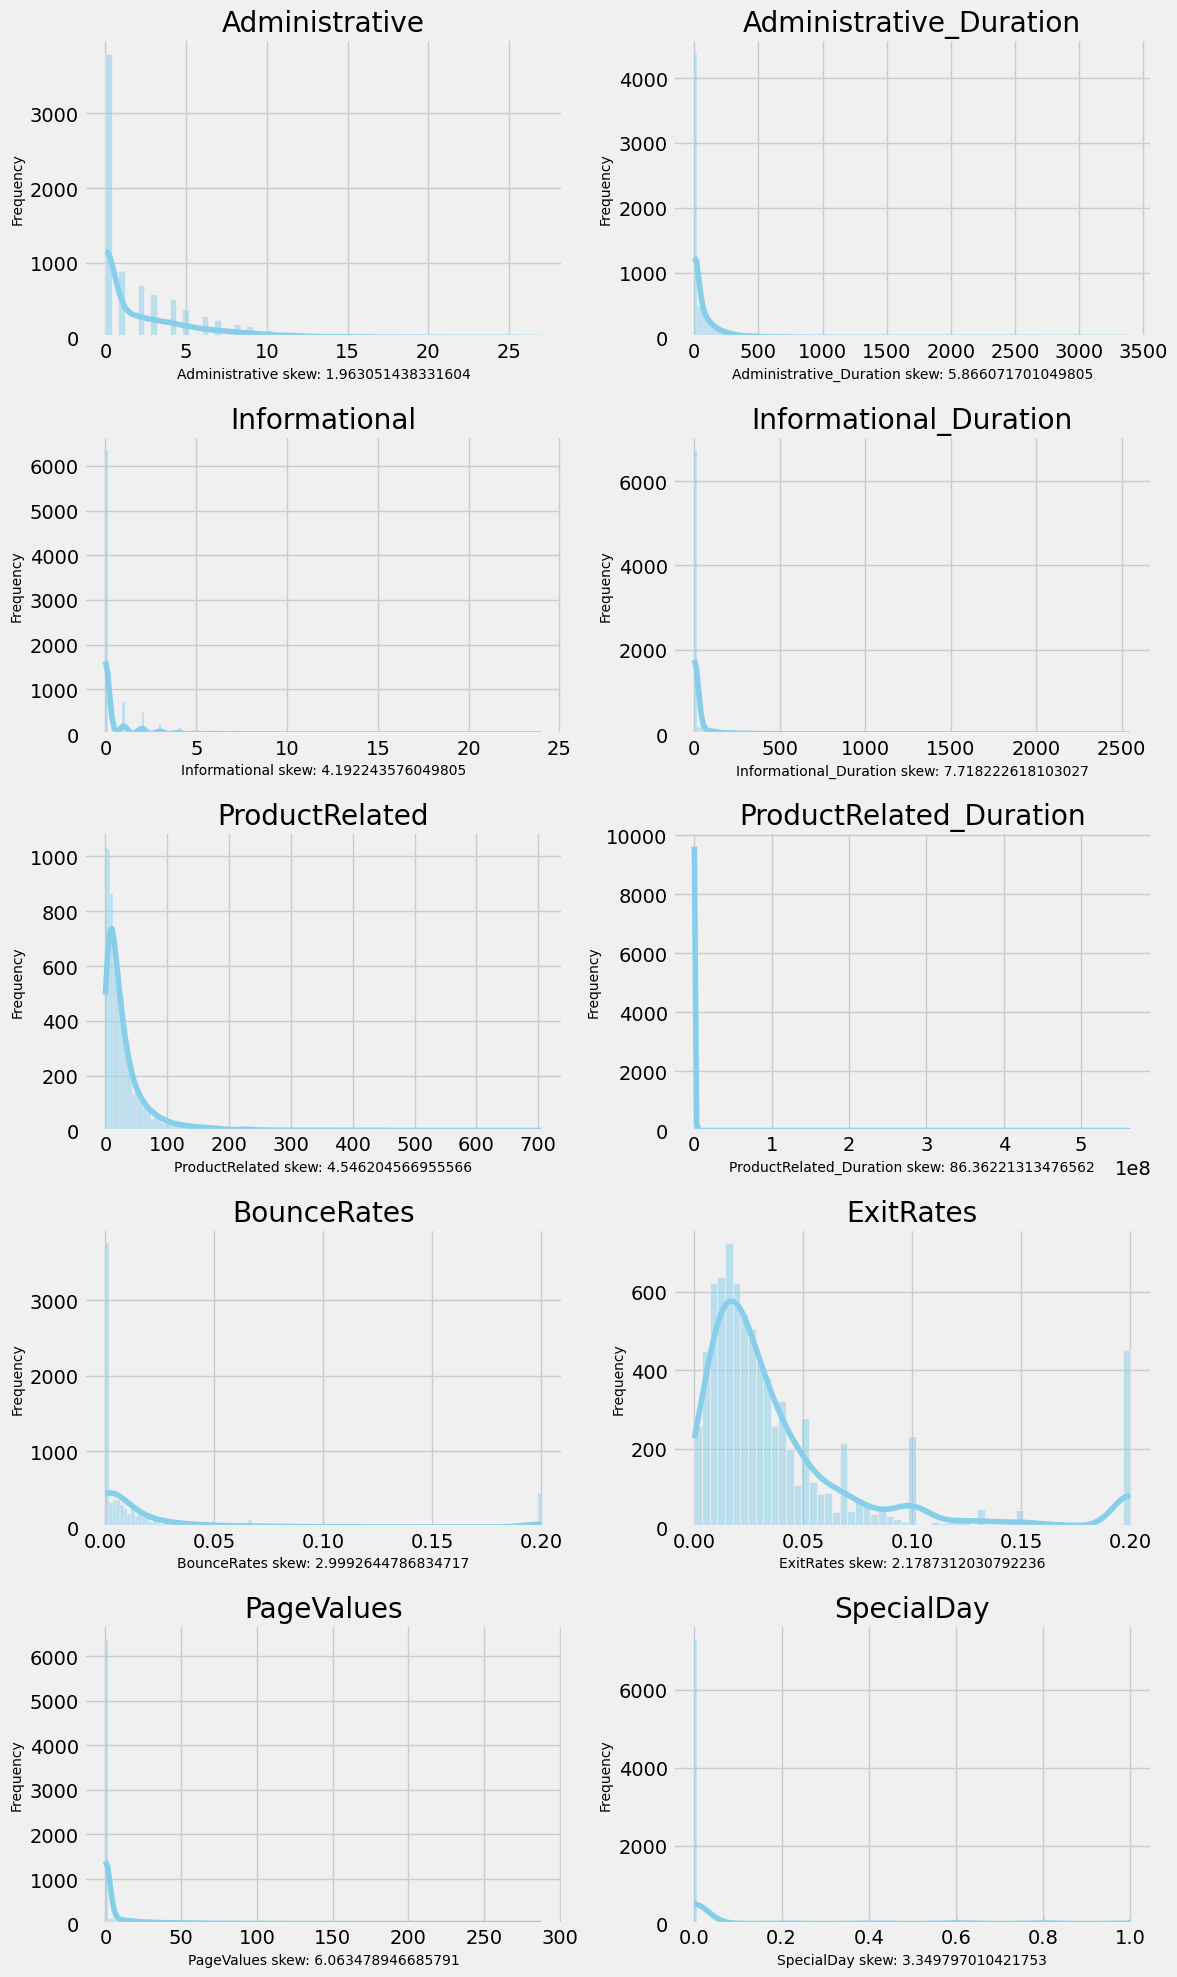

In [4]:
df = data.dropna().copy()
num_plots = len(numeric_cols)
num_rows = (num_plots + 1) // 2 
num_cols = 2 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4)) # 調整整體大小
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue') # 可以調整顏色
    skewness = stats.skew(df[col], bias=False)
    axes[i].set_title(col)
    axes[i].set_xlabel(f"{col} skew: {skewness}", fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
plt.tight_layout()

### 檢查cloumns是否有NA ,ID= 1 這筆有4個欄位NA值 Browser, Region ,TrafficType ,VisitorType,我們取眾數填入,其餘的用預測的方式填入

In [5]:
na_counts = data.isnull().sum()
print("train source nan counts :\n",na_counts[na_counts > 0])
print('---------------------------------------------------------')
print('NA > 1 rows \n',data[data.isnull().sum(axis=1)>1])
for c in ['Browser', 'Region' ,'TrafficType' ,'VisitorType']:
    data.loc[data['ID']==1,c] = data[c].mode().values
print('---------------------------------------------------------')
na_counts = data.isnull().sum()
print("train after replace NA    :\n",na_counts[na_counts > 0])

data_preproc = data.dropna().copy()
for c in numeric_cols:
    data_preproc[c] = (data_preproc[c])**(1/3)


train source nan counts :
 ProductRelated_Duration    1
BounceRates                2
OperatingSystems           1
Browser                    1
Region                     1
TrafficType                1
VisitorType                1
dtype: int64
---------------------------------------------------------
NA > 1 rows 
       ID  Administrative  Administrative_Duration  Informational  \
5378   1             1.0                      0.0            0.0   

      Informational_Duration  ProductRelated  ProductRelated_Duration  \
5378                     0.0             1.0                      0.0   

      BounceRates  ExitRates  PageValues  SpecialDay Month OperatingSystems  \
5378          0.2        0.2         0.0         0.6     2              3.0   

     Browser Region TrafficType VisitorType Weekend Revenue  
5378     NaN    NaN         NaN         NaN       0       0  
---------------------------------------------------------
train after replace NA    :
 ProductRelated_Duration    1
Bo

In [6]:
def fill_na_by_xgb(preproc_data,source_data,na_target,model_type):
    """
    使用模型填值的function
    Args:
        - preproc_data : 整理偏態後的data
        - source_data : 原始data
        - na_target : 待填值的欄位(當作target)
        - model_type : 數值預測 or 分類  
    """
    
    X_features = [c for c in preproc_data.columns if  c != na_target]
    xgb_optimizer = XGBoostOptimizer(X=data_preproc[X_features], y=data_preproc[na_target], model_type=model_type)
    xgb_optimizer.optimize_params(
        optuna_n_trials=100,
        num_boost_round_per_trial=1000,
        early_stopping_rounds_per_trial=1,
        study_name=na_target,
    )
    xgb_optimizer.train_final_model()
    na_data = source_data[source_data[na_target].isna()].reset_index(drop=True)
    na_indices = source_data[source_data[na_target].isna()].reset_index(drop=True).index
    for c in numeric_cols:
        if c != na_target:
            na_data.loc[:,c] =  (na_data[c])**(1/3)
    fill_values = reg_optimizer.predict(na_data[X_features])


    na_data.loc[na_indices, na_target] = fill_values
    
    return na_data


In [7]:
repair_df = pd.DataFrame()
for na_col in na_counts[na_counts > 0].index:
    print(f'starting {na_col}...')
    if data_preproc[na_col].dtype == "float32":
        insert_df = fill_na_by_xgb(data_preproc,data,na_col,'regressor')
    elif data_preproc[na_col].dtype == "category":
        insert_df = fill_na_by_xgb(data_preproc,data,na_col,'classifier')
    else:
        pass
    repair_df = pd.concat([repair_df,insert_df]).reset_index(drop=True)

[I 2025-07-13 20:22:55,637] A new study created in memory with name: ProductRelated_Duration


starting ProductRelated_Duration...
Starting Optuna optimization for 100 trials...


[I 2025-07-13 20:22:55,910] Trial 0 finished with value: 8.584731753195594 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 8.584731753195594.
[I 2025-07-13 20:22:56,090] Trial 1 finished with value: 8.502726921821916 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 8.502726921821916.
[I 2025-07-13 20:22:56,612] Trial 2 finished with value: 8.340286481794973 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 2 with value: 8.340286481794973.
[I 2025-07-13 20:22:56,888] Trial 3 finish


--- Optuna Optimization Finished ---
Best trial number: 99
Best score (MINIMIZE): 7.4239
Mean best boosting rounds: 121
Best parameters:
  max_depth: 5
  learning_rate: 0.09970704143879248
  subsample: 0.6127181796344539
  colsample_bytree: 0.9984982600510777
  min_child_weight: 8
  gamma: 2.850843698797361

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！
starting BounceRates...
Starting Optuna optimization for 100 trials...


[I 2025-07-13 20:23:26,470] Trial 0 finished with value: 0.08859685991483027 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.08859685991483027.
[I 2025-07-13 20:23:26,668] Trial 1 finished with value: 0.1104414535335686 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 0 with value: 0.08859685991483027.
[I 2025-07-13 20:23:27,013] Trial 2 finished with value: 0.10684105080789516 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 0 with value: 0.08859685991483027.
[I 2025-07-13 20:23:27,364] Tri


--- Optuna Optimization Finished ---
Best trial number: 31
Best score (MINIMIZE): 0.0830
Mean best boosting rounds: 255
Best parameters:
  max_depth: 10
  learning_rate: 0.06451442642016939
  subsample: 0.717744896376423
  colsample_bytree: 0.6857784012134432
  min_child_weight: 7
  gamma: 0.040031268657354305

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！
starting OperatingSystems...
Encoded target labels for classification: [0. 1. 2. 3. 4. 5. 6. 7.] -> [0 1 2 3 4 5 6 7]
Starting Optuna optimization for 100 trials...


[I 2025-07-13 20:24:07,834] Trial 0 finished with value: 0.7749505486544812 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.7749505486544812.
[I 2025-07-13 20:24:10,783] Trial 1 finished with value: 0.7696397715401215 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 0.7696397715401215.
[I 2025-07-13 20:24:14,844] Trial 2 finished with value: 0.7727276401375639 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 1 with value: 0.7696397715401215.
[I 2025-07-13 20:24:18,775] Trial 3 


--- Optuna Optimization Finished ---
Best trial number: 65
Best score (MINIMIZE): 0.7642
Mean best boosting rounds: 476
Best parameters:
  max_depth: 3
  learning_rate: 0.04970711616648061
  subsample: 0.9951632577042001
  colsample_bytree: 0.7320668409048042
  min_child_weight: 8
  gamma: 4.501328491610074

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！


In [15]:
data_preproc = pd.concat([data_preproc,repair_df],axis=0).sort_values(by='ID').reset_index(drop= True)
data_preproc.to_csv('./data/fill_na_data.csv',index=False)

In [6]:
data_preproc = pd.read_csv("./data/fill_na_data.csv")

for c in numeric_cols:
    data_preproc[c] = data_preproc[c].astype('float32')
for c in category_cols:
    data_preproc[c] = data_preproc[c].astype('int').astype('category')

data_preproc[target_col] = data_preproc[target_col].astype('int')

X_train, X_valid, y_train, y_valid = train_test_split(
data_preproc[numeric_cols+category_cols], data_preproc[target_col], test_size=0.2, random_state=42)

In [19]:
xgb_optimizer = XGBoostOptimizer(X=X_train, y=y_train, model_type='classifier')
xgb_optimizer.optimize_params(
        optuna_n_trials=100,
        num_boost_round_per_trial=1000,
        early_stopping_rounds_per_trial=5
    )
xgb_optimizer.train_final_model()

[I 2025-07-13 23:05:39,547] A new study created in memory with name: xgboost_optimization


A new study created in memory with name: xgboost_optimization
Starting Optuna optimization for 100 trials...


[I 2025-07-13 23:05:39,837] Trial 0 finished with value: 0.788834702810022 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.788834702810022.


Trial 0 finished with value: 0.788834702810022 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.788834702810022.


[I 2025-07-13 23:05:40,116] Trial 1 finished with value: 0.7870286762818741 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 0.7870286762818741.


Trial 1 finished with value: 0.7870286762818741 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 0.7870286762818741.


[I 2025-07-13 23:05:40,778] Trial 2 finished with value: 0.786156412441448 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 2 with value: 0.786156412441448.


Trial 2 finished with value: 0.786156412441448 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 2 with value: 0.786156412441448.


[I 2025-07-13 23:05:41,367] Trial 3 finished with value: 0.7852796268800706 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 3 with value: 0.7852796268800706.


Trial 3 finished with value: 0.7852796268800706 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:41,715] Trial 4 finished with value: 0.7854219620155881 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 3 with value: 0.7852796268800706.


Trial 4 finished with value: 0.7854219620155881 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:42,335] Trial 5 finished with value: 0.7938399554806501 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 3 with value: 0.7852796268800706.


Trial 5 finished with value: 0.7938399554806501 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:43,086] Trial 6 finished with value: 0.791272024341988 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 3 with value: 0.7852796268800706.


Trial 6 finished with value: 0.791272024341988 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:43,348] Trial 7 finished with value: 0.7893424219597289 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 3 with value: 0.7852796268800706.


Trial 7 finished with value: 0.7893424219597289 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:44,024] Trial 8 finished with value: 0.7957980345485269 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 3 with value: 0.7852796268800706.


Trial 8 finished with value: 0.7957980345485269 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 3 with value: 0.7852796268800706.


[I 2025-07-13 23:05:44,395] Trial 9 finished with value: 0.7817139084124411 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 9 with value: 0.7817139084124411.


Trial 9 finished with value: 0.7817139084124411 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 9 with value: 0.7817139084124411.


[I 2025-07-13 23:05:44,893] Trial 10 finished with value: 0.7815624455897323 and parameters: {'max_depth': 10, 'learning_rate': 0.0609342463851316, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.5089809378074099, 'min_child_weight': 7, 'gamma': 1.4473053146539885}. Best is trial 10 with value: 0.7815624455897323.


Trial 10 finished with value: 0.7815624455897323 and parameters: {'max_depth': 10, 'learning_rate': 0.0609342463851316, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.5089809378074099, 'min_child_weight': 7, 'gamma': 1.4473053146539885}. Best is trial 10 with value: 0.7815624455897323.


[I 2025-07-13 23:05:45,385] Trial 11 finished with value: 0.7834125342885704 and parameters: {'max_depth': 10, 'learning_rate': 0.0661675174455129, 'subsample': 0.6899314844596016, 'colsample_bytree': 0.5018843472355731, 'min_child_weight': 7, 'gamma': 1.3537190236377392}. Best is trial 10 with value: 0.7815624455897323.


Trial 11 finished with value: 0.7834125342885704 and parameters: {'max_depth': 10, 'learning_rate': 0.0661675174455129, 'subsample': 0.6899314844596016, 'colsample_bytree': 0.5018843472355731, 'min_child_weight': 7, 'gamma': 1.3537190236377392}. Best is trial 10 with value: 0.7815624455897323.


[I 2025-07-13 23:05:45,893] Trial 12 finished with value: 0.7839488159338914 and parameters: {'max_depth': 9, 'learning_rate': 0.0516075375320119, 'subsample': 0.7248174281144494, 'colsample_bytree': 0.659143125062404, 'min_child_weight': 8, 'gamma': 1.5316629601384857}. Best is trial 10 with value: 0.7815624455897323.


Trial 12 finished with value: 0.7839488159338914 and parameters: {'max_depth': 9, 'learning_rate': 0.0516075375320119, 'subsample': 0.7248174281144494, 'colsample_bytree': 0.659143125062404, 'min_child_weight': 8, 'gamma': 1.5316629601384857}. Best is trial 10 with value: 0.7815624455897323.


[I 2025-07-13 23:05:46,285] Trial 13 finished with value: 0.7858715499247271 and parameters: {'max_depth': 8, 'learning_rate': 0.06985952537395923, 'subsample': 0.5306573178166409, 'colsample_bytree': 0.5035287188633475, 'min_child_weight': 8, 'gamma': 3.384090290478076}. Best is trial 10 with value: 0.7815624455897323.


Trial 13 finished with value: 0.7858715499247271 and parameters: {'max_depth': 8, 'learning_rate': 0.06985952537395923, 'subsample': 0.5306573178166409, 'colsample_bytree': 0.5035287188633475, 'min_child_weight': 8, 'gamma': 3.384090290478076}. Best is trial 10 with value: 0.7815624455897323.


[I 2025-07-13 23:05:46,904] Trial 14 finished with value: 0.7742368078305828 and parameters: {'max_depth': 10, 'learning_rate': 0.04805864512413175, 'subsample': 0.6663562828278531, 'colsample_bytree': 0.6135695058254393, 'min_child_weight': 5, 'gamma': 0.03195003545821984}. Best is trial 14 with value: 0.7742368078305828.


Trial 14 finished with value: 0.7742368078305828 and parameters: {'max_depth': 10, 'learning_rate': 0.04805864512413175, 'subsample': 0.6663562828278531, 'colsample_bytree': 0.6135695058254393, 'min_child_weight': 5, 'gamma': 0.03195003545821984}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:47,499] Trial 15 finished with value: 0.7755771676903962 and parameters: {'max_depth': 10, 'learning_rate': 0.047523214749475066, 'subsample': 0.6723434253965188, 'colsample_bytree': 0.665289833992663, 'min_child_weight': 5, 'gamma': 0.10433033090560699}. Best is trial 14 with value: 0.7742368078305828.


Trial 15 finished with value: 0.7755771676903962 and parameters: {'max_depth': 10, 'learning_rate': 0.047523214749475066, 'subsample': 0.6723434253965188, 'colsample_bytree': 0.665289833992663, 'min_child_weight': 5, 'gamma': 0.10433033090560699}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:48,133] Trial 16 finished with value: 0.776985399950098 and parameters: {'max_depth': 9, 'learning_rate': 0.04270575342799221, 'subsample': 0.7500098280590355, 'colsample_bytree': 0.680371010605396, 'min_child_weight': 5, 'gamma': 0.09122644455463749}. Best is trial 14 with value: 0.7742368078305828.


Trial 16 finished with value: 0.776985399950098 and parameters: {'max_depth': 9, 'learning_rate': 0.04270575342799221, 'subsample': 0.7500098280590355, 'colsample_bytree': 0.680371010605396, 'min_child_weight': 5, 'gamma': 0.09122644455463749}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:51,033] Trial 17 finished with value: 0.778741316178617 and parameters: {'max_depth': 10, 'learning_rate': 0.05028832372818808, 'subsample': 0.6439540442206741, 'colsample_bytree': 0.6545613962314292, 'min_child_weight': 5, 'gamma': 0.736494341677159}. Best is trial 14 with value: 0.7742368078305828.


Trial 17 finished with value: 0.778741316178617 and parameters: {'max_depth': 10, 'learning_rate': 0.05028832372818808, 'subsample': 0.6439540442206741, 'colsample_bytree': 0.6545613962314292, 'min_child_weight': 5, 'gamma': 0.736494341677159}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:51,617] Trial 18 finished with value: 0.7845698291362946 and parameters: {'max_depth': 8, 'learning_rate': 0.04211403909296309, 'subsample': 0.9790786324781681, 'colsample_bytree': 0.7320832480224758, 'min_child_weight': 6, 'gamma': 0.728894307535588}. Best is trial 14 with value: 0.7742368078305828.


Trial 18 finished with value: 0.7845698291362946 and parameters: {'max_depth': 8, 'learning_rate': 0.04211403909296309, 'subsample': 0.9790786324781681, 'colsample_bytree': 0.7320832480224758, 'min_child_weight': 6, 'gamma': 0.728894307535588}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:53,287] Trial 19 finished with value: 0.7817553964966101 and parameters: {'max_depth': 8, 'learning_rate': 0.011882220983506359, 'subsample': 0.9114068531568305, 'colsample_bytree': 0.6285309550759541, 'min_child_weight': 4, 'gamma': 0.06223515874667445}. Best is trial 14 with value: 0.7742368078305828.


Trial 19 finished with value: 0.7817553964966101 and parameters: {'max_depth': 8, 'learning_rate': 0.011882220983506359, 'subsample': 0.9114068531568305, 'colsample_bytree': 0.6285309550759541, 'min_child_weight': 4, 'gamma': 0.06223515874667445}. Best is trial 14 with value: 0.7742368078305828.


[I 2025-07-13 23:05:53,787] Trial 20 finished with value: 0.7710312808232984 and parameters: {'max_depth': 10, 'learning_rate': 0.07542682766092407, 'subsample': 0.7574190171413552, 'colsample_bytree': 0.5489324244033762, 'min_child_weight': 3, 'gamma': 0.9133918767103375}. Best is trial 20 with value: 0.7710312808232984.


Trial 20 finished with value: 0.7710312808232984 and parameters: {'max_depth': 10, 'learning_rate': 0.07542682766092407, 'subsample': 0.7574190171413552, 'colsample_bytree': 0.5489324244033762, 'min_child_weight': 3, 'gamma': 0.9133918767103375}. Best is trial 20 with value: 0.7710312808232984.


[I 2025-07-13 23:05:54,294] Trial 21 finished with value: 0.771292018320068 and parameters: {'max_depth': 10, 'learning_rate': 0.07436586848224452, 'subsample': 0.7348741668429798, 'colsample_bytree': 0.575426395963394, 'min_child_weight': 3, 'gamma': 0.5971741053336226}. Best is trial 20 with value: 0.7710312808232984.


Trial 21 finished with value: 0.771292018320068 and parameters: {'max_depth': 10, 'learning_rate': 0.07436586848224452, 'subsample': 0.7348741668429798, 'colsample_bytree': 0.575426395963394, 'min_child_weight': 3, 'gamma': 0.5971741053336226}. Best is trial 20 with value: 0.7710312808232984.


[I 2025-07-13 23:05:54,745] Trial 22 finished with value: 0.7687853217353353 and parameters: {'max_depth': 9, 'learning_rate': 0.0816280985704216, 'subsample': 0.7529274132649292, 'colsample_bytree': 0.5576026580204613, 'min_child_weight': 3, 'gamma': 0.8935988447292478}. Best is trial 22 with value: 0.7687853217353353.


Trial 22 finished with value: 0.7687853217353353 and parameters: {'max_depth': 9, 'learning_rate': 0.0816280985704216, 'subsample': 0.7529274132649292, 'colsample_bytree': 0.5576026580204613, 'min_child_weight': 3, 'gamma': 0.8935988447292478}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:55,197] Trial 23 finished with value: 0.7727101127194494 and parameters: {'max_depth': 9, 'learning_rate': 0.07725379304155527, 'subsample': 0.7669644854077319, 'colsample_bytree': 0.5545320705584508, 'min_child_weight': 3, 'gamma': 1.006818104614415}. Best is trial 22 with value: 0.7687853217353353.


Trial 23 finished with value: 0.7727101127194494 and parameters: {'max_depth': 9, 'learning_rate': 0.07725379304155527, 'subsample': 0.7669644854077319, 'colsample_bytree': 0.5545320705584508, 'min_child_weight': 3, 'gamma': 1.006818104614415}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:55,569] Trial 24 finished with value: 0.7782146439371099 and parameters: {'max_depth': 9, 'learning_rate': 0.0799638990522224, 'subsample': 0.722631540153452, 'colsample_bytree': 0.5453769363428775, 'min_child_weight': 3, 'gamma': 1.9760192207745226}. Best is trial 22 with value: 0.7687853217353353.


Trial 24 finished with value: 0.7782146439371099 and parameters: {'max_depth': 9, 'learning_rate': 0.0799638990522224, 'subsample': 0.722631540153452, 'colsample_bytree': 0.5453769363428775, 'min_child_weight': 3, 'gamma': 1.9760192207745226}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:56,029] Trial 25 finished with value: 0.7793551018180415 and parameters: {'max_depth': 8, 'learning_rate': 0.07234968096922313, 'subsample': 0.78507697267901, 'colsample_bytree': 0.5469031828396116, 'min_child_weight': 2, 'gamma': 1.0986985199927946}. Best is trial 22 with value: 0.7687853217353353.


Trial 25 finished with value: 0.7793551018180415 and parameters: {'max_depth': 8, 'learning_rate': 0.07234968096922313, 'subsample': 0.78507697267901, 'colsample_bytree': 0.5469031828396116, 'min_child_weight': 2, 'gamma': 1.0986985199927946}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:56,592] Trial 26 finished with value: 0.7730599970585627 and parameters: {'max_depth': 10, 'learning_rate': 0.058824388809190026, 'subsample': 0.8406087029714921, 'colsample_bytree': 0.700241559839021, 'min_child_weight': 3, 'gamma': 0.6079666383251685}. Best is trial 22 with value: 0.7687853217353353.


Trial 26 finished with value: 0.7730599970585627 and parameters: {'max_depth': 10, 'learning_rate': 0.058824388809190026, 'subsample': 0.8406087029714921, 'colsample_bytree': 0.700241559839021, 'min_child_weight': 3, 'gamma': 0.6079666383251685}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:56,970] Trial 27 finished with value: 0.7838329493593819 and parameters: {'max_depth': 9, 'learning_rate': 0.08504794150599823, 'subsample': 0.7225689006852716, 'colsample_bytree': 0.5804337459742868, 'min_child_weight': 2, 'gamma': 2.128079511593746}. Best is trial 22 with value: 0.7687853217353353.


Trial 27 finished with value: 0.7838329493593819 and parameters: {'max_depth': 9, 'learning_rate': 0.08504794150599823, 'subsample': 0.7225689006852716, 'colsample_bytree': 0.5804337459742868, 'min_child_weight': 2, 'gamma': 2.128079511593746}. Best is trial 22 with value: 0.7687853217353353.


[I 2025-07-13 23:05:57,597] Trial 28 finished with value: 0.7668385707249457 and parameters: {'max_depth': 10, 'learning_rate': 0.06464185931283567, 'subsample': 0.8980580275416029, 'colsample_bytree': 0.6296545778977569, 'min_child_weight': 1, 'gamma': 0.5183041188726447}. Best is trial 28 with value: 0.7668385707249457.


Trial 28 finished with value: 0.7668385707249457 and parameters: {'max_depth': 10, 'learning_rate': 0.06464185931283567, 'subsample': 0.8980580275416029, 'colsample_bytree': 0.6296545778977569, 'min_child_weight': 1, 'gamma': 0.5183041188726447}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:05:57,840] Trial 29 finished with value: 0.7890381277640007 and parameters: {'max_depth': 4, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.6304733264465078, 'min_child_weight': 1, 'gamma': 3.11431358622367}. Best is trial 28 with value: 0.7668385707249457.


Trial 29 finished with value: 0.7890381277640007 and parameters: {'max_depth': 4, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.6304733264465078, 'min_child_weight': 1, 'gamma': 3.11431358622367}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:05:58,246] Trial 30 finished with value: 0.7855134761540972 and parameters: {'max_depth': 8, 'learning_rate': 0.06560012157222903, 'subsample': 0.913758733483923, 'colsample_bytree': 0.7808067412678819, 'min_child_weight': 1, 'gamma': 1.1524104595760112}. Best is trial 28 with value: 0.7668385707249457.


Trial 30 finished with value: 0.7855134761540972 and parameters: {'max_depth': 8, 'learning_rate': 0.06560012157222903, 'subsample': 0.913758733483923, 'colsample_bytree': 0.7808067412678819, 'min_child_weight': 1, 'gamma': 1.1524104595760112}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:05:58,812] Trial 31 finished with value: 0.7714932904139683 and parameters: {'max_depth': 10, 'learning_rate': 0.07389352987133414, 'subsample': 0.8823028680715025, 'colsample_bytree': 0.5406675614665996, 'min_child_weight': 2, 'gamma': 0.47498256753229257}. Best is trial 28 with value: 0.7668385707249457.


Trial 31 finished with value: 0.7714932904139683 and parameters: {'max_depth': 10, 'learning_rate': 0.07389352987133414, 'subsample': 0.8823028680715025, 'colsample_bytree': 0.5406675614665996, 'min_child_weight': 2, 'gamma': 0.47498256753229257}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:05:59,241] Trial 32 finished with value: 0.7752966584040495 and parameters: {'max_depth': 9, 'learning_rate': 0.08447942659038382, 'subsample': 0.8183696431355583, 'colsample_bytree': 0.5280771797076238, 'min_child_weight': 4, 'gamma': 1.0150441346268781}. Best is trial 28 with value: 0.7668385707249457.


Trial 32 finished with value: 0.7752966584040495 and parameters: {'max_depth': 9, 'learning_rate': 0.08447942659038382, 'subsample': 0.8183696431355583, 'colsample_bytree': 0.5280771797076238, 'min_child_weight': 4, 'gamma': 1.0150441346268781}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:05:59,854] Trial 33 finished with value: 0.7689615199207088 and parameters: {'max_depth': 10, 'learning_rate': 0.06288082221922522, 'subsample': 0.951239010912797, 'colsample_bytree': 0.5831236759287465, 'min_child_weight': 2, 'gamma': 0.43336450754419775}. Best is trial 28 with value: 0.7668385707249457.


Trial 33 finished with value: 0.7689615199207088 and parameters: {'max_depth': 10, 'learning_rate': 0.06288082221922522, 'subsample': 0.951239010912797, 'colsample_bytree': 0.5831236759287465, 'min_child_weight': 2, 'gamma': 0.43336450754419775}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:06:00,470] Trial 34 finished with value: 0.7709183712619739 and parameters: {'max_depth': 9, 'learning_rate': 0.057899152710163694, 'subsample': 0.875015254291353, 'colsample_bytree': 0.612113685641862, 'min_child_weight': 1, 'gamma': 0.38876290969198235}. Best is trial 28 with value: 0.7668385707249457.


Trial 34 finished with value: 0.7709183712619739 and parameters: {'max_depth': 9, 'learning_rate': 0.057899152710163694, 'subsample': 0.875015254291353, 'colsample_bytree': 0.612113685641862, 'min_child_weight': 1, 'gamma': 0.38876290969198235}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:06:01,065] Trial 35 finished with value: 0.7708913972292346 and parameters: {'max_depth': 9, 'learning_rate': 0.05955077772211976, 'subsample': 0.9512632875377857, 'colsample_bytree': 0.6047958231190319, 'min_child_weight': 1, 'gamma': 0.48821731009037866}. Best is trial 28 with value: 0.7668385707249457.


Trial 35 finished with value: 0.7708913972292346 and parameters: {'max_depth': 9, 'learning_rate': 0.05955077772211976, 'subsample': 0.9512632875377857, 'colsample_bytree': 0.6047958231190319, 'min_child_weight': 1, 'gamma': 0.48821731009037866}. Best is trial 28 with value: 0.7668385707249457.


[I 2025-07-13 23:06:01,527] Trial 36 finished with value: 0.7667008178005593 and parameters: {'max_depth': 8, 'learning_rate': 0.06602550453558581, 'subsample': 0.9554586619602692, 'colsample_bytree': 0.6378549666240827, 'min_child_weight': 2, 'gamma': 0.37940832349603426}. Best is trial 36 with value: 0.7667008178005593.


Trial 36 finished with value: 0.7667008178005593 and parameters: {'max_depth': 8, 'learning_rate': 0.06602550453558581, 'subsample': 0.9554586619602692, 'colsample_bytree': 0.6378549666240827, 'min_child_weight': 2, 'gamma': 0.37940832349603426}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:02,077] Trial 37 finished with value: 0.7711692849188426 and parameters: {'max_depth': 8, 'learning_rate': 0.0660208941901907, 'subsample': 0.9356239927772184, 'colsample_bytree': 0.6411121474287371, 'min_child_weight': 2, 'gamma': 0.2980085831564029}. Best is trial 36 with value: 0.7667008178005593.


Trial 37 finished with value: 0.7711692849188426 and parameters: {'max_depth': 8, 'learning_rate': 0.0660208941901907, 'subsample': 0.9356239927772184, 'colsample_bytree': 0.6411121474287371, 'min_child_weight': 2, 'gamma': 0.2980085831564029}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:02,449] Trial 38 finished with value: 0.7805888070358251 and parameters: {'max_depth': 6, 'learning_rate': 0.06421675883062075, 'subsample': 0.9487697682152443, 'colsample_bytree': 0.702536930694983, 'min_child_weight': 2, 'gamma': 1.298458497823495}. Best is trial 36 with value: 0.7667008178005593.


Trial 38 finished with value: 0.7805888070358251 and parameters: {'max_depth': 6, 'learning_rate': 0.06421675883062075, 'subsample': 0.9487697682152443, 'colsample_bytree': 0.702536930694983, 'min_child_weight': 2, 'gamma': 1.298458497823495}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:02,967] Trial 39 finished with value: 0.7755289207799091 and parameters: {'max_depth': 9, 'learning_rate': 0.05530330717539498, 'subsample': 0.9923950370324112, 'colsample_bytree': 0.6816428083377775, 'min_child_weight': 4, 'gamma': 0.7601844013459697}. Best is trial 36 with value: 0.7667008178005593.


Trial 39 finished with value: 0.7755289207799091 and parameters: {'max_depth': 9, 'learning_rate': 0.05530330717539498, 'subsample': 0.9923950370324112, 'colsample_bytree': 0.6816428083377775, 'min_child_weight': 4, 'gamma': 0.7601844013459697}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:03,344] Trial 40 finished with value: 0.7804392443373288 and parameters: {'max_depth': 7, 'learning_rate': 0.08727237546227115, 'subsample': 0.8526913489614122, 'colsample_bytree': 0.5721619660581035, 'min_child_weight': 1, 'gamma': 1.698621949751569}. Best is trial 36 with value: 0.7667008178005593.


Trial 40 finished with value: 0.7804392443373288 and parameters: {'max_depth': 7, 'learning_rate': 0.08727237546227115, 'subsample': 0.8526913489614122, 'colsample_bytree': 0.5721619660581035, 'min_child_weight': 1, 'gamma': 1.698621949751569}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:03,915] Trial 41 finished with value: 0.7733380991842578 and parameters: {'max_depth': 9, 'learning_rate': 0.06882006158458061, 'subsample': 0.9630663929044565, 'colsample_bytree': 0.6046868105935859, 'min_child_weight': 1, 'gamma': 0.3440755833986735}. Best is trial 36 with value: 0.7667008178005593.


Trial 41 finished with value: 0.7733380991842578 and parameters: {'max_depth': 9, 'learning_rate': 0.06882006158458061, 'subsample': 0.9630663929044565, 'colsample_bytree': 0.6046868105935859, 'min_child_weight': 1, 'gamma': 0.3440755833986735}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:04,407] Trial 42 finished with value: 0.7828152470700768 and parameters: {'max_depth': 9, 'learning_rate': 0.06200227182159289, 'subsample': 0.9345317558394874, 'colsample_bytree': 0.9633556669174963, 'min_child_weight': 2, 'gamma': 0.5052242853355857}. Best is trial 36 with value: 0.7667008178005593.


Trial 42 finished with value: 0.7828152470700768 and parameters: {'max_depth': 9, 'learning_rate': 0.06200227182159289, 'subsample': 0.9345317558394874, 'colsample_bytree': 0.9633556669174963, 'min_child_weight': 2, 'gamma': 0.5052242853355857}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:05,005] Trial 43 finished with value: 0.7772651510288474 and parameters: {'max_depth': 8, 'learning_rate': 0.05470522614896651, 'subsample': 0.965946308365782, 'colsample_bytree': 0.5924723281861644, 'min_child_weight': 1, 'gamma': 0.9040362465556169}. Best is trial 36 with value: 0.7667008178005593.


Trial 43 finished with value: 0.7772651510288474 and parameters: {'max_depth': 8, 'learning_rate': 0.05470522614896651, 'subsample': 0.965946308365782, 'colsample_bytree': 0.5924723281861644, 'min_child_weight': 1, 'gamma': 0.9040362465556169}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:05,847] Trial 44 finished with value: 0.7740098491383807 and parameters: {'max_depth': 10, 'learning_rate': 0.036386624947615104, 'subsample': 0.999915896416205, 'colsample_bytree': 0.7460600767918331, 'min_child_weight': 2, 'gamma': 0.3824490448890279}. Best is trial 36 with value: 0.7667008178005593.


Trial 44 finished with value: 0.7740098491383807 and parameters: {'max_depth': 10, 'learning_rate': 0.036386624947615104, 'subsample': 0.999915896416205, 'colsample_bytree': 0.7460600767918331, 'min_child_weight': 2, 'gamma': 0.3824490448890279}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:06,241] Trial 45 finished with value: 0.7784566221524731 and parameters: {'max_depth': 7, 'learning_rate': 0.08088685070512516, 'subsample': 0.8984487905175222, 'colsample_bytree': 0.6362296055293797, 'min_child_weight': 1, 'gamma': 0.6387043393325208}. Best is trial 36 with value: 0.7667008178005593.


Trial 45 finished with value: 0.7784566221524731 and parameters: {'max_depth': 7, 'learning_rate': 0.08088685070512516, 'subsample': 0.8984487905175222, 'colsample_bytree': 0.6362296055293797, 'min_child_weight': 1, 'gamma': 0.6387043393325208}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:06,563] Trial 46 finished with value: 0.7907865636936753 and parameters: {'max_depth': 5, 'learning_rate': 0.07017323557709214, 'subsample': 0.9350927951048077, 'colsample_bytree': 0.5234004024644628, 'min_child_weight': 2, 'gamma': 4.959782326816242}. Best is trial 36 with value: 0.7667008178005593.


Trial 46 finished with value: 0.7907865636936753 and parameters: {'max_depth': 5, 'learning_rate': 0.07017323557709214, 'subsample': 0.9350927951048077, 'colsample_bytree': 0.5234004024644628, 'min_child_weight': 2, 'gamma': 4.959782326816242}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:07,084] Trial 47 finished with value: 0.7845211372442558 and parameters: {'max_depth': 10, 'learning_rate': 0.05507540857951033, 'subsample': 0.5890384999154384, 'colsample_bytree': 0.8479376201664546, 'min_child_weight': 3, 'gamma': 1.2783099693781002}. Best is trial 36 with value: 0.7667008178005593.


Trial 47 finished with value: 0.7845211372442558 and parameters: {'max_depth': 10, 'learning_rate': 0.05507540857951033, 'subsample': 0.5890384999154384, 'colsample_bytree': 0.8479376201664546, 'min_child_weight': 3, 'gamma': 1.2783099693781002}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:07,442] Trial 48 finished with value: 0.7790312885686017 and parameters: {'max_depth': 9, 'learning_rate': 0.09127502741609352, 'subsample': 0.8183606935998954, 'colsample_bytree': 0.5673000535784961, 'min_child_weight': 1, 'gamma': 2.2125787362433167}. Best is trial 36 with value: 0.7667008178005593.


Trial 48 finished with value: 0.7790312885686017 and parameters: {'max_depth': 9, 'learning_rate': 0.09127502741609352, 'subsample': 0.8183606935998954, 'colsample_bytree': 0.5673000535784961, 'min_child_weight': 1, 'gamma': 2.2125787362433167}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:07,838] Trial 49 finished with value: 0.786414637906584 and parameters: {'max_depth': 8, 'learning_rate': 0.061716069473143995, 'subsample': 0.9582664347831222, 'colsample_bytree': 0.6162193265572393, 'min_child_weight': 2, 'gamma': 2.864984821054549}. Best is trial 36 with value: 0.7667008178005593.


Trial 49 finished with value: 0.786414637906584 and parameters: {'max_depth': 8, 'learning_rate': 0.061716069473143995, 'subsample': 0.9582664347831222, 'colsample_bytree': 0.6162193265572393, 'min_child_weight': 2, 'gamma': 2.864984821054549}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:08,410] Trial 50 finished with value: 0.787443979914714 and parameters: {'max_depth': 10, 'learning_rate': 0.042122757668590895, 'subsample': 0.8918689402488051, 'colsample_bytree': 0.6713445768474305, 'min_child_weight': 4, 'gamma': 4.576313396472237}. Best is trial 36 with value: 0.7667008178005593.


Trial 50 finished with value: 0.787443979914714 and parameters: {'max_depth': 10, 'learning_rate': 0.042122757668590895, 'subsample': 0.8918689402488051, 'colsample_bytree': 0.6713445768474305, 'min_child_weight': 4, 'gamma': 4.576313396472237}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:09,087] Trial 51 finished with value: 0.7685179080928282 and parameters: {'max_depth': 9, 'learning_rate': 0.05763321217928813, 'subsample': 0.8687406138647514, 'colsample_bytree': 0.5959253074180305, 'min_child_weight': 1, 'gamma': 0.2506799505644335}. Best is trial 36 with value: 0.7667008178005593.


Trial 51 finished with value: 0.7685179080928282 and parameters: {'max_depth': 9, 'learning_rate': 0.05763321217928813, 'subsample': 0.8687406138647514, 'colsample_bytree': 0.5959253074180305, 'min_child_weight': 1, 'gamma': 0.2506799505644335}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:09,752] Trial 52 finished with value: 0.7667618233737319 and parameters: {'max_depth': 9, 'learning_rate': 0.053040692008785584, 'subsample': 0.8631976008251968, 'colsample_bytree': 0.5887328621572676, 'min_child_weight': 1, 'gamma': 0.20838349552173457}. Best is trial 36 with value: 0.7667008178005593.


Trial 52 finished with value: 0.7667618233737319 and parameters: {'max_depth': 9, 'learning_rate': 0.053040692008785584, 'subsample': 0.8631976008251968, 'colsample_bytree': 0.5887328621572676, 'min_child_weight': 1, 'gamma': 0.20838349552173457}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:10,473] Trial 53 finished with value: 0.7712221615506787 and parameters: {'max_depth': 9, 'learning_rate': 0.0470106642134367, 'subsample': 0.8524385924428729, 'colsample_bytree': 0.6488258508517695, 'min_child_weight': 1, 'gamma': 0.1513599051948309}. Best is trial 36 with value: 0.7667008178005593.


Trial 53 finished with value: 0.7712221615506787 and parameters: {'max_depth': 9, 'learning_rate': 0.0470106642134367, 'subsample': 0.8524385924428729, 'colsample_bytree': 0.6488258508517695, 'min_child_weight': 1, 'gamma': 0.1513599051948309}. Best is trial 36 with value: 0.7667008178005593.


[I 2025-07-13 23:06:11,149] Trial 54 finished with value: 0.7632642300418563 and parameters: {'max_depth': 10, 'learning_rate': 0.051186689499929404, 'subsample': 0.8665373298476942, 'colsample_bytree': 0.5857685146436699, 'min_child_weight': 2, 'gamma': 0.18232764698179982}. Best is trial 54 with value: 0.7632642300418563.


Trial 54 finished with value: 0.7632642300418563 and parameters: {'max_depth': 10, 'learning_rate': 0.051186689499929404, 'subsample': 0.8665373298476942, 'colsample_bytree': 0.5857685146436699, 'min_child_weight': 2, 'gamma': 0.18232764698179982}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:11,715] Trial 55 finished with value: 0.7687493042606931 and parameters: {'max_depth': 8, 'learning_rate': 0.05224259389591122, 'subsample': 0.795424003960526, 'colsample_bytree': 0.5239545184528476, 'min_child_weight': 2, 'gamma': 0.02465013922962256}. Best is trial 54 with value: 0.7632642300418563.


Trial 55 finished with value: 0.7687493042606931 and parameters: {'max_depth': 8, 'learning_rate': 0.05224259389591122, 'subsample': 0.795424003960526, 'colsample_bytree': 0.5239545184528476, 'min_child_weight': 2, 'gamma': 0.02465013922962256}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:12,535] Trial 56 finished with value: 0.7737857632140754 and parameters: {'max_depth': 8, 'learning_rate': 0.03389688639621987, 'subsample': 0.8628722558295464, 'colsample_bytree': 0.5294387896318642, 'min_child_weight': 1, 'gamma': 0.037459109115243513}. Best is trial 54 with value: 0.7632642300418563.


Trial 56 finished with value: 0.7737857632140754 and parameters: {'max_depth': 8, 'learning_rate': 0.03389688639621987, 'subsample': 0.8628722558295464, 'colsample_bytree': 0.5294387896318642, 'min_child_weight': 1, 'gamma': 0.037459109115243513}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:13,075] Trial 57 finished with value: 0.7757219559320754 and parameters: {'max_depth': 7, 'learning_rate': 0.05256058497481018, 'subsample': 0.8304542130653747, 'colsample_bytree': 0.512931333112138, 'min_child_weight': 2, 'gamma': 0.24069103482690105}. Best is trial 54 with value: 0.7632642300418563.


Trial 57 finished with value: 0.7757219559320754 and parameters: {'max_depth': 7, 'learning_rate': 0.05256058497481018, 'subsample': 0.8304542130653747, 'colsample_bytree': 0.512931333112138, 'min_child_weight': 2, 'gamma': 0.24069103482690105}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:13,661] Trial 58 finished with value: 0.7818980686132819 and parameters: {'max_depth': 8, 'learning_rate': 0.04562619970583927, 'subsample': 0.8083780001798023, 'colsample_bytree': 0.5910737796177109, 'min_child_weight': 9, 'gamma': 0.01606839167141332}. Best is trial 54 with value: 0.7632642300418563.


Trial 58 finished with value: 0.7818980686132819 and parameters: {'max_depth': 8, 'learning_rate': 0.04562619970583927, 'subsample': 0.8083780001798023, 'colsample_bytree': 0.5910737796177109, 'min_child_weight': 9, 'gamma': 0.01606839167141332}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:14,131] Trial 59 finished with value: 0.7898441061027055 and parameters: {'max_depth': 10, 'learning_rate': 0.05002793135018613, 'subsample': 0.7744299147341083, 'colsample_bytree': 0.6174498556035213, 'min_child_weight': 3, 'gamma': 3.827511053116965}. Best is trial 54 with value: 0.7632642300418563.


Trial 59 finished with value: 0.7898441061027055 and parameters: {'max_depth': 10, 'learning_rate': 0.05002793135018613, 'subsample': 0.7744299147341083, 'colsample_bytree': 0.6174498556035213, 'min_child_weight': 3, 'gamma': 3.827511053116965}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:14,838] Trial 60 finished with value: 0.7860497577994183 and parameters: {'max_depth': 6, 'learning_rate': 0.0377280133339106, 'subsample': 0.7946430673109057, 'colsample_bytree': 0.686444689368731, 'min_child_weight': 7, 'gamma': 0.21496445835239697}. Best is trial 54 with value: 0.7632642300418563.


Trial 60 finished with value: 0.7860497577994183 and parameters: {'max_depth': 6, 'learning_rate': 0.0377280133339106, 'subsample': 0.7946430673109057, 'colsample_bytree': 0.686444689368731, 'min_child_weight': 7, 'gamma': 0.21496445835239697}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:15,386] Trial 61 finished with value: 0.7693049586595496 and parameters: {'max_depth': 9, 'learning_rate': 0.0571240268041925, 'subsample': 0.9188601775205272, 'colsample_bytree': 0.5558265529355487, 'min_child_weight': 2, 'gamma': 0.7520534350333878}. Best is trial 54 with value: 0.7632642300418563.


Trial 61 finished with value: 0.7693049586595496 and parameters: {'max_depth': 9, 'learning_rate': 0.0571240268041925, 'subsample': 0.9188601775205272, 'colsample_bytree': 0.5558265529355487, 'min_child_weight': 2, 'gamma': 0.7520534350333878}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:15,965] Trial 62 finished with value: 0.7746904135536494 and parameters: {'max_depth': 8, 'learning_rate': 0.05069199969103941, 'subsample': 0.7034154354264898, 'colsample_bytree': 0.5630955676871534, 'min_child_weight': 3, 'gamma': 0.8945631840296309}. Best is trial 54 with value: 0.7632642300418563.


Trial 62 finished with value: 0.7746904135536494 and parameters: {'max_depth': 8, 'learning_rate': 0.05069199969103941, 'subsample': 0.7034154354264898, 'colsample_bytree': 0.5630955676871534, 'min_child_weight': 3, 'gamma': 0.8945631840296309}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:16,460] Trial 63 finished with value: 0.7754109618355008 and parameters: {'max_depth': 7, 'learning_rate': 0.06749745990360531, 'subsample': 0.8638657420606632, 'colsample_bytree': 0.5023156206019519, 'min_child_weight': 1, 'gamma': 0.27221526530321394}. Best is trial 54 with value: 0.7632642300418563.


Trial 63 finished with value: 0.7754109618355008 and parameters: {'max_depth': 7, 'learning_rate': 0.06749745990360531, 'subsample': 0.8638657420606632, 'colsample_bytree': 0.5023156206019519, 'min_child_weight': 1, 'gamma': 0.27221526530321394}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:17,162] Trial 64 finished with value: 0.7658004142556698 and parameters: {'max_depth': 10, 'learning_rate': 0.04555956923724307, 'subsample': 0.8832843643804389, 'colsample_bytree': 0.538182516008279, 'min_child_weight': 2, 'gamma': 0.5482687650719766}. Best is trial 54 with value: 0.7632642300418563.


Trial 64 finished with value: 0.7658004142556698 and parameters: {'max_depth': 10, 'learning_rate': 0.04555956923724307, 'subsample': 0.8832843643804389, 'colsample_bytree': 0.538182516008279, 'min_child_weight': 2, 'gamma': 0.5482687650719766}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:17,925] Trial 65 finished with value: 0.7707320344459462 and parameters: {'max_depth': 10, 'learning_rate': 0.039217160918548946, 'subsample': 0.8836181694988504, 'colsample_bytree': 0.5371954754367944, 'min_child_weight': 2, 'gamma': 0.6620576844436126}. Best is trial 54 with value: 0.7632642300418563.


Trial 65 finished with value: 0.7707320344459462 and parameters: {'max_depth': 10, 'learning_rate': 0.039217160918548946, 'subsample': 0.8836181694988504, 'colsample_bytree': 0.5371954754367944, 'min_child_weight': 2, 'gamma': 0.6620576844436126}. Best is trial 54 with value: 0.7632642300418563.


[I 2025-07-13 23:06:18,879] Trial 66 finished with value: 0.7610078811520811 and parameters: {'max_depth': 10, 'learning_rate': 0.04367572313739679, 'subsample': 0.8334071291285686, 'colsample_bytree': 0.5923707933572193, 'min_child_weight': 1, 'gamma': 0.17763561108973744}. Best is trial 66 with value: 0.7610078811520811.


Trial 66 finished with value: 0.7610078811520811 and parameters: {'max_depth': 10, 'learning_rate': 0.04367572313739679, 'subsample': 0.8334071291285686, 'colsample_bytree': 0.5923707933572193, 'min_child_weight': 1, 'gamma': 0.17763561108973744}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:19,664] Trial 67 finished with value: 0.7622059663665567 and parameters: {'max_depth': 10, 'learning_rate': 0.04464798514011515, 'subsample': 0.834423901734295, 'colsample_bytree': 0.627416858915059, 'min_child_weight': 1, 'gamma': 0.5450379843883673}. Best is trial 66 with value: 0.7610078811520811.


Trial 67 finished with value: 0.7622059663665567 and parameters: {'max_depth': 10, 'learning_rate': 0.04464798514011515, 'subsample': 0.834423901734295, 'colsample_bytree': 0.627416858915059, 'min_child_weight': 1, 'gamma': 0.5450379843883673}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:20,711] Trial 68 finished with value: 0.771676439671346 and parameters: {'max_depth': 10, 'learning_rate': 0.03107434346233825, 'subsample': 0.8460547975215446, 'colsample_bytree': 0.6244839469305832, 'min_child_weight': 1, 'gamma': 0.5279386642973249}. Best is trial 66 with value: 0.7610078811520811.


Trial 68 finished with value: 0.771676439671346 and parameters: {'max_depth': 10, 'learning_rate': 0.03107434346233825, 'subsample': 0.8460547975215446, 'colsample_bytree': 0.6244839469305832, 'min_child_weight': 1, 'gamma': 0.5279386642973249}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:21,429] Trial 69 finished with value: 0.77278973283856 and parameters: {'max_depth': 10, 'learning_rate': 0.041817285415353, 'subsample': 0.832149323203263, 'colsample_bytree': 0.664584999178292, 'min_child_weight': 1, 'gamma': 1.197275233275091}. Best is trial 66 with value: 0.7610078811520811.


Trial 69 finished with value: 0.77278973283856 and parameters: {'max_depth': 10, 'learning_rate': 0.041817285415353, 'subsample': 0.832149323203263, 'colsample_bytree': 0.664584999178292, 'min_child_weight': 1, 'gamma': 1.197275233275091}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:22,097] Trial 70 finished with value: 0.7721495391283075 and parameters: {'max_depth': 10, 'learning_rate': 0.04551847594033421, 'subsample': 0.892191823169313, 'colsample_bytree': 0.7124626402091153, 'min_child_weight': 1, 'gamma': 0.8074977029105153}. Best is trial 66 with value: 0.7610078811520811.


Trial 70 finished with value: 0.7721495391283075 and parameters: {'max_depth': 10, 'learning_rate': 0.04551847594033421, 'subsample': 0.892191823169313, 'colsample_bytree': 0.7124626402091153, 'min_child_weight': 1, 'gamma': 0.8074977029105153}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:22,877] Trial 71 finished with value: 0.7656841264547172 and parameters: {'max_depth': 10, 'learning_rate': 0.04776106197596035, 'subsample': 0.8676606588418668, 'colsample_bytree': 0.5964250827763795, 'min_child_weight': 1, 'gamma': 0.2291874035512877}. Best is trial 66 with value: 0.7610078811520811.


Trial 71 finished with value: 0.7656841264547172 and parameters: {'max_depth': 10, 'learning_rate': 0.04776106197596035, 'subsample': 0.8676606588418668, 'colsample_bytree': 0.5964250827763795, 'min_child_weight': 1, 'gamma': 0.2291874035512877}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:23,687] Trial 72 finished with value: 0.7686861458274423 and parameters: {'max_depth': 10, 'learning_rate': 0.04481748126823711, 'subsample': 0.9222956146197571, 'colsample_bytree': 0.6476637655009072, 'min_child_weight': 1, 'gamma': 0.19467595108113095}. Best is trial 66 with value: 0.7610078811520811.


Trial 72 finished with value: 0.7686861458274423 and parameters: {'max_depth': 10, 'learning_rate': 0.04481748126823711, 'subsample': 0.9222956146197571, 'colsample_bytree': 0.6476637655009072, 'min_child_weight': 1, 'gamma': 0.19467595108113095}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:24,361] Trial 73 finished with value: 0.7626652479247982 and parameters: {'max_depth': 10, 'learning_rate': 0.0487028729122502, 'subsample': 0.8315357204380363, 'colsample_bytree': 0.5829058464907397, 'min_child_weight': 2, 'gamma': 0.5319373851940907}. Best is trial 66 with value: 0.7610078811520811.


Trial 73 finished with value: 0.7626652479247982 and parameters: {'max_depth': 10, 'learning_rate': 0.0487028729122502, 'subsample': 0.8315357204380363, 'colsample_bytree': 0.5829058464907397, 'min_child_weight': 2, 'gamma': 0.5319373851940907}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:24,993] Trial 74 finished with value: 0.7704111560192908 and parameters: {'max_depth': 10, 'learning_rate': 0.04865385268795916, 'subsample': 0.8192567240541611, 'colsample_bytree': 0.5794715566274181, 'min_child_weight': 2, 'gamma': 0.6315658656065626}. Best is trial 66 with value: 0.7610078811520811.


Trial 74 finished with value: 0.7704111560192908 and parameters: {'max_depth': 10, 'learning_rate': 0.04865385268795916, 'subsample': 0.8192567240541611, 'colsample_bytree': 0.5794715566274181, 'min_child_weight': 2, 'gamma': 0.6315658656065626}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:25,877] Trial 75 finished with value: 0.7687711063652813 and parameters: {'max_depth': 10, 'learning_rate': 0.033390966343213244, 'subsample': 0.828298632613689, 'colsample_bytree': 0.5875576005519099, 'min_child_weight': 2, 'gamma': 0.41241247210173415}. Best is trial 66 with value: 0.7610078811520811.


Trial 75 finished with value: 0.7687711063652813 and parameters: {'max_depth': 10, 'learning_rate': 0.033390966343213244, 'subsample': 0.828298632613689, 'colsample_bytree': 0.5875576005519099, 'min_child_weight': 2, 'gamma': 0.41241247210173415}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:27,037] Trial 76 finished with value: 0.7804224931805323 and parameters: {'max_depth': 10, 'learning_rate': 0.02009781322648152, 'subsample': 0.8581455534248564, 'colsample_bytree': 0.6080891063429247, 'min_child_weight': 6, 'gamma': 1.02161946619346}. Best is trial 66 with value: 0.7610078811520811.


Trial 76 finished with value: 0.7804224931805323 and parameters: {'max_depth': 10, 'learning_rate': 0.02009781322648152, 'subsample': 0.8581455534248564, 'colsample_bytree': 0.6080891063429247, 'min_child_weight': 6, 'gamma': 1.02161946619346}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:27,816] Trial 77 finished with value: 0.7680241737677106 and parameters: {'max_depth': 10, 'learning_rate': 0.04017701702670665, 'subsample': 0.8722393064025645, 'colsample_bytree': 0.5690856438862132, 'min_child_weight': 2, 'gamma': 0.1598266811532978}. Best is trial 66 with value: 0.7610078811520811.


Trial 77 finished with value: 0.7680241737677106 and parameters: {'max_depth': 10, 'learning_rate': 0.04017701702670665, 'subsample': 0.8722393064025645, 'colsample_bytree': 0.5690856438862132, 'min_child_weight': 2, 'gamma': 0.1598266811532978}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:28,316] Trial 78 finished with value: 0.791967584525309 and parameters: {'max_depth': 3, 'learning_rate': 0.04398690100706295, 'subsample': 0.8405930579154158, 'colsample_bytree': 0.5545127535772088, 'min_child_weight': 1, 'gamma': 0.345578757825197}. Best is trial 66 with value: 0.7610078811520811.


Trial 78 finished with value: 0.791967584525309 and parameters: {'max_depth': 3, 'learning_rate': 0.04398690100706295, 'subsample': 0.8405930579154158, 'colsample_bytree': 0.5545127535772088, 'min_child_weight': 1, 'gamma': 0.345578757825197}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:28,894] Trial 79 finished with value: 0.7787919924401571 and parameters: {'max_depth': 10, 'learning_rate': 0.04825966664243847, 'subsample': 0.8068027295186977, 'colsample_bytree': 0.7968374701203189, 'min_child_weight': 3, 'gamma': 0.5690815241496132}. Best is trial 66 with value: 0.7610078811520811.


Trial 79 finished with value: 0.7787919924401571 and parameters: {'max_depth': 10, 'learning_rate': 0.04825966664243847, 'subsample': 0.8068027295186977, 'colsample_bytree': 0.7968374701203189, 'min_child_weight': 3, 'gamma': 0.5690815241496132}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:29,377] Trial 80 finished with value: 0.7750602350435016 and parameters: {'max_depth': 9, 'learning_rate': 0.05359703513286212, 'subsample': 0.7688916706547585, 'colsample_bytree': 0.6027887881551872, 'min_child_weight': 3, 'gamma': 1.4475352748691397}. Best is trial 66 with value: 0.7610078811520811.


Trial 80 finished with value: 0.7750602350435016 and parameters: {'max_depth': 9, 'learning_rate': 0.05359703513286212, 'subsample': 0.7688916706547585, 'colsample_bytree': 0.6027887881551872, 'min_child_weight': 3, 'gamma': 1.4475352748691397}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:30,014] Trial 81 finished with value: 0.766439849758325 and parameters: {'max_depth': 10, 'learning_rate': 0.051065184050818994, 'subsample': 0.9017583060445482, 'colsample_bytree': 0.6299792825629177, 'min_child_weight': 1, 'gamma': 0.45062469629101126}. Best is trial 66 with value: 0.7610078811520811.


Trial 81 finished with value: 0.766439849758325 and parameters: {'max_depth': 10, 'learning_rate': 0.051065184050818994, 'subsample': 0.9017583060445482, 'colsample_bytree': 0.6299792825629177, 'min_child_weight': 1, 'gamma': 0.45062469629101126}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:30,743] Trial 82 finished with value: 0.7681023517241224 and parameters: {'max_depth': 10, 'learning_rate': 0.049910151293760044, 'subsample': 0.877447604776208, 'colsample_bytree': 0.6296749001027174, 'min_child_weight': 1, 'gamma': 0.40272669118451004}. Best is trial 66 with value: 0.7610078811520811.


Trial 82 finished with value: 0.7681023517241224 and parameters: {'max_depth': 10, 'learning_rate': 0.049910151293760044, 'subsample': 0.877447604776208, 'colsample_bytree': 0.6296749001027174, 'min_child_weight': 1, 'gamma': 0.40272669118451004}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:31,356] Trial 83 finished with value: 0.7813636503571024 and parameters: {'max_depth': 10, 'learning_rate': 0.04666639184156286, 'subsample': 0.9070463209658498, 'colsample_bytree': 0.9003944113215047, 'min_child_weight': 2, 'gamma': 0.16575788489575938}. Best is trial 66 with value: 0.7610078811520811.


Trial 83 finished with value: 0.7813636503571024 and parameters: {'max_depth': 10, 'learning_rate': 0.04666639184156286, 'subsample': 0.9070463209658498, 'colsample_bytree': 0.9003944113215047, 'min_child_weight': 2, 'gamma': 0.16575788489575938}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:32,091] Trial 84 finished with value: 0.7711480120410948 and parameters: {'max_depth': 10, 'learning_rate': 0.043239863452813276, 'subsample': 0.8870813153159011, 'colsample_bytree': 0.5804161871292536, 'min_child_weight': 1, 'gamma': 0.8022707934397506}. Best is trial 66 with value: 0.7610078811520811.


Trial 84 finished with value: 0.7711480120410948 and parameters: {'max_depth': 10, 'learning_rate': 0.043239863452813276, 'subsample': 0.8870813153159011, 'colsample_bytree': 0.5804161871292536, 'min_child_weight': 1, 'gamma': 0.8022707934397506}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:32,669] Trial 85 finished with value: 0.7707679676752996 and parameters: {'max_depth': 9, 'learning_rate': 0.05303980696018496, 'subsample': 0.9810910513175044, 'colsample_bytree': 0.6522778326856115, 'min_child_weight': 2, 'gamma': 0.5118079477555068}. Best is trial 66 with value: 0.7610078811520811.


Trial 85 finished with value: 0.7707679676752996 and parameters: {'max_depth': 9, 'learning_rate': 0.05303980696018496, 'subsample': 0.9810910513175044, 'colsample_bytree': 0.6522778326856115, 'min_child_weight': 2, 'gamma': 0.5118079477555068}. Best is trial 66 with value: 0.7610078811520811.


[I 2025-07-13 23:06:33,498] Trial 86 finished with value: 0.760232807285339 and parameters: {'max_depth': 10, 'learning_rate': 0.04088532061257575, 'subsample': 0.8418010823555225, 'colsample_bytree': 0.6205481346784847, 'min_child_weight': 1, 'gamma': 0.31730830278415}. Best is trial 86 with value: 0.760232807285339.


Trial 86 finished with value: 0.760232807285339 and parameters: {'max_depth': 10, 'learning_rate': 0.04088532061257575, 'subsample': 0.8418010823555225, 'colsample_bytree': 0.6205481346784847, 'min_child_weight': 1, 'gamma': 0.31730830278415}. Best is trial 86 with value: 0.760232807285339.


[I 2025-07-13 23:06:34,292] Trial 87 finished with value: 0.7771908330286866 and parameters: {'max_depth': 10, 'learning_rate': 0.03848716591134258, 'subsample': 0.9304992909541678, 'colsample_bytree': 0.6396870638550267, 'min_child_weight': 2, 'gamma': 0.684161418723368}. Best is trial 86 with value: 0.760232807285339.


Trial 87 finished with value: 0.7771908330286866 and parameters: {'max_depth': 10, 'learning_rate': 0.03848716591134258, 'subsample': 0.9304992909541678, 'colsample_bytree': 0.6396870638550267, 'min_child_weight': 2, 'gamma': 0.684161418723368}. Best is trial 86 with value: 0.760232807285339.


[I 2025-07-13 23:06:35,150] Trial 88 finished with value: 0.763259287094462 and parameters: {'max_depth': 10, 'learning_rate': 0.04052897831916311, 'subsample': 0.8425564942221441, 'colsample_bytree': 0.6195783185766744, 'min_child_weight': 1, 'gamma': 0.34149837341452105}. Best is trial 86 with value: 0.760232807285339.


Trial 88 finished with value: 0.763259287094462 and parameters: {'max_depth': 10, 'learning_rate': 0.04052897831916311, 'subsample': 0.8425564942221441, 'colsample_bytree': 0.6195783185766744, 'min_child_weight': 1, 'gamma': 0.34149837341452105}. Best is trial 86 with value: 0.760232807285339.


[I 2025-07-13 23:06:36,022] Trial 89 finished with value: 0.7588054787630767 and parameters: {'max_depth': 10, 'learning_rate': 0.04059610288333989, 'subsample': 0.8474069063776182, 'colsample_bytree': 0.6195219463811749, 'min_child_weight': 1, 'gamma': 0.006884833914961308}. Best is trial 89 with value: 0.7588054787630767.


Trial 89 finished with value: 0.7588054787630767 and parameters: {'max_depth': 10, 'learning_rate': 0.04059610288333989, 'subsample': 0.8474069063776182, 'colsample_bytree': 0.6195219463811749, 'min_child_weight': 1, 'gamma': 0.006884833914961308}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:36,964] Trial 90 finished with value: 0.7663097456233604 and parameters: {'max_depth': 10, 'learning_rate': 0.03508090723029542, 'subsample': 0.8411751471518312, 'colsample_bytree': 0.6197861772348153, 'min_child_weight': 1, 'gamma': 0.10117376755596656}. Best is trial 89 with value: 0.7588054787630767.


Trial 90 finished with value: 0.7663097456233604 and parameters: {'max_depth': 10, 'learning_rate': 0.03508090723029542, 'subsample': 0.8411751471518312, 'colsample_bytree': 0.6197861772348153, 'min_child_weight': 1, 'gamma': 0.10117376755596656}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:37,892] Trial 91 finished with value: 0.7640155158698014 and parameters: {'max_depth': 10, 'learning_rate': 0.03536367572009769, 'subsample': 0.8389215061266101, 'colsample_bytree': 0.6174692725898705, 'min_child_weight': 1, 'gamma': 0.0785948210648541}. Best is trial 89 with value: 0.7588054787630767.


Trial 91 finished with value: 0.7640155158698014 and parameters: {'max_depth': 10, 'learning_rate': 0.03536367572009769, 'subsample': 0.8389215061266101, 'colsample_bytree': 0.6174692725898705, 'min_child_weight': 1, 'gamma': 0.0785948210648541}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:38,853] Trial 92 finished with value: 0.7639963353619521 and parameters: {'max_depth': 10, 'learning_rate': 0.029054202386216144, 'subsample': 0.782597706135335, 'colsample_bytree': 0.6017071129378914, 'min_child_weight': 1, 'gamma': 0.31842412809720066}. Best is trial 89 with value: 0.7588054787630767.


Trial 92 finished with value: 0.7639963353619521 and parameters: {'max_depth': 10, 'learning_rate': 0.029054202386216144, 'subsample': 0.782597706135335, 'colsample_bytree': 0.6017071129378914, 'min_child_weight': 1, 'gamma': 0.31842412809720066}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:39,929] Trial 93 finished with value: 0.7660516044035129 and parameters: {'max_depth': 10, 'learning_rate': 0.026127720527772038, 'subsample': 0.7861986537015849, 'colsample_bytree': 0.6067658801514483, 'min_child_weight': 1, 'gamma': 0.29841858207101946}. Best is trial 89 with value: 0.7588054787630767.


Trial 93 finished with value: 0.7660516044035129 and parameters: {'max_depth': 10, 'learning_rate': 0.026127720527772038, 'subsample': 0.7861986537015849, 'colsample_bytree': 0.6067658801514483, 'min_child_weight': 1, 'gamma': 0.29841858207101946}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:40,961] Trial 94 finished with value: 0.7677543307741506 and parameters: {'max_depth': 10, 'learning_rate': 0.02950427769746049, 'subsample': 0.8173278616263422, 'colsample_bytree': 0.6596768220536515, 'min_child_weight': 1, 'gamma': 0.00833112787277368}. Best is trial 89 with value: 0.7588054787630767.


Trial 94 finished with value: 0.7677543307741506 and parameters: {'max_depth': 10, 'learning_rate': 0.02950427769746049, 'subsample': 0.8173278616263422, 'colsample_bytree': 0.6596768220536515, 'min_child_weight': 1, 'gamma': 0.00833112787277368}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:41,791] Trial 95 finished with value: 0.7623657503762882 and parameters: {'max_depth': 10, 'learning_rate': 0.04078015839092246, 'subsample': 0.7373775163406101, 'colsample_bytree': 0.5969652182864691, 'min_child_weight': 1, 'gamma': 0.11509197738846698}. Best is trial 89 with value: 0.7588054787630767.


Trial 95 finished with value: 0.7623657503762882 and parameters: {'max_depth': 10, 'learning_rate': 0.04078015839092246, 'subsample': 0.7373775163406101, 'colsample_bytree': 0.5969652182864691, 'min_child_weight': 1, 'gamma': 0.11509197738846698}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:42,602] Trial 96 finished with value: 0.7600542639942012 and parameters: {'max_depth': 10, 'learning_rate': 0.040849169933324575, 'subsample': 0.7811010067595068, 'colsample_bytree': 0.6177340189960392, 'min_child_weight': 1, 'gamma': 0.12947352841478296}. Best is trial 89 with value: 0.7588054787630767.


Trial 96 finished with value: 0.7600542639942012 and parameters: {'max_depth': 10, 'learning_rate': 0.040849169933324575, 'subsample': 0.7811010067595068, 'colsample_bytree': 0.6177340189960392, 'min_child_weight': 1, 'gamma': 0.12947352841478296}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:43,082] Trial 97 finished with value: 0.790456075863206 and parameters: {'max_depth': 4, 'learning_rate': 0.04142284061885034, 'subsample': 0.7804687540893687, 'colsample_bytree': 0.5714072471250644, 'min_child_weight': 1, 'gamma': 0.324981372780832}. Best is trial 89 with value: 0.7588054787630767.


Trial 97 finished with value: 0.790456075863206 and parameters: {'max_depth': 4, 'learning_rate': 0.04142284061885034, 'subsample': 0.7804687540893687, 'colsample_bytree': 0.5714072471250644, 'min_child_weight': 1, 'gamma': 0.324981372780832}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:44,530] Trial 98 finished with value: 0.7690898924220381 and parameters: {'max_depth': 10, 'learning_rate': 0.020476747137070497, 'subsample': 0.7424421138801867, 'colsample_bytree': 0.5978048483324806, 'min_child_weight': 1, 'gamma': 0.130700348963049}. Best is trial 89 with value: 0.7588054787630767.


Trial 98 finished with value: 0.7690898924220381 and parameters: {'max_depth': 10, 'learning_rate': 0.020476747137070497, 'subsample': 0.7424421138801867, 'colsample_bytree': 0.5978048483324806, 'min_child_weight': 1, 'gamma': 0.130700348963049}. Best is trial 89 with value: 0.7588054787630767.


[I 2025-07-13 23:06:45,447] Trial 99 finished with value: 0.7692972493799481 and parameters: {'max_depth': 9, 'learning_rate': 0.03171103897660729, 'subsample': 0.7637929711256344, 'colsample_bytree': 0.669746344971245, 'min_child_weight': 1, 'gamma': 0.0059268085258256265}. Best is trial 89 with value: 0.7588054787630767.


Trial 99 finished with value: 0.7692972493799481 and parameters: {'max_depth': 9, 'learning_rate': 0.03171103897660729, 'subsample': 0.7637929711256344, 'colsample_bytree': 0.669746344971245, 'min_child_weight': 1, 'gamma': 0.0059268085258256265}. Best is trial 89 with value: 0.7588054787630767.

--- Optuna Optimization Finished ---
Best trial number: 89
Best score (MINIMIZE): 0.7588
Mean best boosting rounds: 122
Best parameters:
  max_depth: 10
  learning_rate: 0.04059610288333989
  subsample: 0.8474069063776182
  colsample_bytree: 0.6195219463811749
  min_child_weight: 1
  gamma: 0.006884833914961308

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！


In [20]:
pred_val = xgb_optimizer.predict(X_valid)

print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_val.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_val.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_val.astype(int)))

Confusion Matrix : 
 [[1319   57]
 [ 113  131]]
Precision :  0.6968085106382979
Recall :  0.5368852459016393


In [22]:
cat_optimizer = CatBoostOptimizer(
        X=X_train,
        y=y_train,
        model_type='classifier',
        categorical_features=category_cols
    )

    
cat_optimizer.optimize(n_trials=100, n_splits=5, metric='roc_auc', direction='maximize') # Fewer trials for quick demo

cat_optimizer.train_best_model()

[I 2025-07-13 23:06:45,622] A new study created in memory with name: no-name-dbae6cac-281a-407e-9ecc-3985d29a3a53


Starting Optuna optimization for CatBoost (classifier)...
Optimizing for metric: 'roc_auc' with direction: 'maximize'
Using 5-fold cross-validation.
A new study created in memory with name: no-name-dbae6cac-281a-407e-9ecc-3985d29a3a53


[I 2025-07-13 23:06:55,302] Trial 0 finished with value: -0.9253076937386947 and parameters: {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.


Trial 0 finished with value: -0.9253076937386947 and parameters: {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.
Trial 0 finished with roc_auc = 0.9253 and params: {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:07:03,581] Trial 1 finished with value: -0.9320509677191813 and parameters: {'iterations': 128, 'learning_rate': 0.18276027831785724, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'random_strength': 0.18182496720710062, 'border_count': 73, 'bagging_temperature': 0.3042422429595377, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.


Trial 1 finished with value: -0.9320509677191813 and parameters: {'iterations': 128, 'learning_rate': 0.18276027831785724, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'random_strength': 0.18182496720710062, 'border_count': 73, 'bagging_temperature': 0.3042422429595377, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.
Trial 1 finished with roc_auc = 0.9321 and params: {'iterations': 128, 'learning_rate': 0.18276027831785724, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'random_strength': 0.18182496720710062, 'border_count': 73, 'bagging_temperature': 0.3042422429595377, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:07:17,656] Trial 2 finished with value: -0.9324126423130705 and parameters: {'iterations': 957, 'learning_rate': 0.01518747922672247, 'depth': 6, 'l2_leaf_reg': 0.029204338471814112, 'random_strength': 0.45606998421703593, 'border_count': 207, 'bagging_temperature': 0.19967378215835974, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.


Trial 2 finished with value: -0.9324126423130705 and parameters: {'iterations': 957, 'learning_rate': 0.01518747922672247, 'depth': 6, 'l2_leaf_reg': 0.029204338471814112, 'random_strength': 0.45606998421703593, 'border_count': 207, 'bagging_temperature': 0.19967378215835974, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.
Trial 2 finished with roc_auc = 0.9324 and params: {'iterations': 957, 'learning_rate': 0.01518747922672247, 'depth': 6, 'l2_leaf_reg': 0.029204338471814112, 'random_strength': 0.45606998421703593, 'border_count': 207, 'bagging_temperature': 0.19967378215835974, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:07:30,826] Trial 3 finished with value: -0.9330178226287668 and parameters: {'iterations': 951, 'learning_rate': 0.016666983286066417, 'depth': 4, 'l2_leaf_reg': 6.245139574743075, 'random_strength': 0.9656320330745594, 'border_count': 213, 'bagging_temperature': 0.3046137691733707, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.


Trial 3 finished with value: -0.9330178226287668 and parameters: {'iterations': 951, 'learning_rate': 0.016666983286066417, 'depth': 4, 'l2_leaf_reg': 6.245139574743075, 'random_strength': 0.9656320330745594, 'border_count': 213, 'bagging_temperature': 0.3046137691733707, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.
Trial 3 finished with roc_auc = 0.9330 and params: {'iterations': 951, 'learning_rate': 0.016666983286066417, 'depth': 4, 'l2_leaf_reg': 6.245139574743075, 'random_strength': 0.9656320330745594, 'border_count': 213, 'bagging_temperature': 0.3046137691733707, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:07:37,943] Trial 4 finished with value: -0.9339281553290585 and parameters: {'iterations': 270, 'learning_rate': 0.04407984038169244, 'depth': 4, 'l2_leaf_reg': 4.337920697490942, 'random_strength': 0.2587799816000169, 'border_count': 180, 'bagging_temperature': 0.31171107608941095, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.


Trial 4 finished with value: -0.9339281553290585 and parameters: {'iterations': 270, 'learning_rate': 0.04407984038169244, 'depth': 4, 'l2_leaf_reg': 4.337920697490942, 'random_strength': 0.2587799816000169, 'border_count': 180, 'bagging_temperature': 0.31171107608941095, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.
Trial 4 finished with roc_auc = 0.9339 and params: {'iterations': 270, 'learning_rate': 0.04407984038169244, 'depth': 4, 'l2_leaf_reg': 4.337920697490942, 'random_strength': 0.2587799816000169, 'border_count': 180, 'bagging_temperature': 0.31171107608941095, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:07:53,638] Trial 5 finished with value: -0.9330511699552894 and parameters: {'iterations': 1458, 'learning_rate': 0.10196967939171485, 'depth': 10, 'l2_leaf_reg': 3.7958531426706403, 'random_strength': 0.5978999788110851, 'border_count': 238, 'bagging_temperature': 0.0884925020519195, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39, 'max_leaves': 19}. Best is trial 0 with value: -0.9253076937386947.


Trial 5 finished with value: -0.9330511699552894 and parameters: {'iterations': 1458, 'learning_rate': 0.10196967939171485, 'depth': 10, 'l2_leaf_reg': 3.7958531426706403, 'random_strength': 0.5978999788110851, 'border_count': 238, 'bagging_temperature': 0.0884925020519195, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39, 'max_leaves': 19}. Best is trial 0 with value: -0.9253076937386947.
Trial 5 finished with roc_auc = 0.9331 and params: {'iterations': 1458, 'learning_rate': 0.10196967939171485, 'depth': 10, 'l2_leaf_reg': 3.7958531426706403, 'random_strength': 0.5978999788110851, 'border_count': 238, 'bagging_temperature': 0.0884925020519195, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39, 'max_leaves': 19}


[I 2025-07-13 23:08:04,614] Trial 6 finished with value: -0.9322406698166075 and parameters: {'iterations': 1261, 'learning_rate': 0.02911701023242742, 'depth': 5, 'l2_leaf_reg': 0.14817820606039092, 'random_strength': 0.14092422497476265, 'border_count': 211, 'bagging_temperature': 0.07455064367977082, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.


Trial 6 finished with value: -0.9322406698166075 and parameters: {'iterations': 1261, 'learning_rate': 0.02911701023242742, 'depth': 5, 'l2_leaf_reg': 0.14817820606039092, 'random_strength': 0.14092422497476265, 'border_count': 211, 'bagging_temperature': 0.07455064367977082, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.
Trial 6 finished with roc_auc = 0.9322 and params: {'iterations': 1261, 'learning_rate': 0.02911701023242742, 'depth': 5, 'l2_leaf_reg': 0.14817820606039092, 'random_strength': 0.14092422497476265, 'border_count': 211, 'bagging_temperature': 0.07455064367977082, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:08:11,373] Trial 7 finished with value: -0.9341907496104014 and parameters: {'iterations': 107, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 0.8241925264876453, 'random_strength': 0.7712703466859457, 'border_count': 48, 'bagging_temperature': 0.3584657285442726, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.


Trial 7 finished with value: -0.9341907496104014 and parameters: {'iterations': 107, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 0.8241925264876453, 'random_strength': 0.7712703466859457, 'border_count': 48, 'bagging_temperature': 0.3584657285442726, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.9253076937386947.
Trial 7 finished with roc_auc = 0.9342 and params: {'iterations': 107, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 0.8241925264876453, 'random_strength': 0.7712703466859457, 'border_count': 48, 'bagging_temperature': 0.3584657285442726, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:08:44,452] Trial 8 finished with value: -0.9330731049355723 and parameters: {'iterations': 563, 'learning_rate': 0.012097379927033842, 'depth': 6, 'l2_leaf_reg': 0.01998634077852888, 'random_strength': 0.7296061783380641, 'border_count': 174, 'bagging_temperature': 0.8872127425763265, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 77, 'max_leaves': 37}. Best is trial 0 with value: -0.9253076937386947.


Trial 8 finished with value: -0.9330731049355723 and parameters: {'iterations': 563, 'learning_rate': 0.012097379927033842, 'depth': 6, 'l2_leaf_reg': 0.01998634077852888, 'random_strength': 0.7296061783380641, 'border_count': 174, 'bagging_temperature': 0.8872127425763265, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 77, 'max_leaves': 37}. Best is trial 0 with value: -0.9253076937386947.
Trial 8 finished with roc_auc = 0.9331 and params: {'iterations': 563, 'learning_rate': 0.012097379927033842, 'depth': 6, 'l2_leaf_reg': 0.01998634077852888, 'random_strength': 0.7296061783380641, 'border_count': 174, 'bagging_temperature': 0.8872127425763265, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 77, 'max_leaves': 37}


[I 2025-07-13 23:08:53,812] Trial 9 finished with value: -0.9314671549934685 and parameters: {'iterations': 1180, 'learning_rate': 0.043897812845882046, 'depth': 7, 'l2_leaf_reg': 0.05130551760589835, 'random_strength': 0.02541912674409519, 'border_count': 56, 'bagging_temperature': 0.03142918568673425, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.


Trial 9 finished with value: -0.9314671549934685 and parameters: {'iterations': 1180, 'learning_rate': 0.043897812845882046, 'depth': 7, 'l2_leaf_reg': 0.05130551760589835, 'random_strength': 0.02541912674409519, 'border_count': 56, 'bagging_temperature': 0.03142918568673425, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.9253076937386947.
Trial 9 finished with roc_auc = 0.9315 and params: {'iterations': 1180, 'learning_rate': 0.043897812845882046, 'depth': 7, 'l2_leaf_reg': 0.05130551760589835, 'random_strength': 0.02541912674409519, 'border_count': 56, 'bagging_temperature': 0.03142918568673425, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:09:08,136] Trial 10 finished with value: -0.9203123497637293 and parameters: {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9203123497637293.


Trial 10 finished with value: -0.9203123497637293 and parameters: {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9203123497637293.
Trial 10 finished with roc_auc = 0.9203 and params: {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:09:34,670] Trial 11 finished with value: -0.9195138994928957 and parameters: {'iterations': 569, 'learning_rate': 0.09134562731480685, 'depth': 10, 'l2_leaf_reg': 0.001171506226182121, 'random_strength': 0.3941087118085442, 'border_count': 114, 'bagging_temperature': 0.6760934721865332, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 11 finished with value: -0.9195138994928957 and parameters: {'iterations': 569, 'learning_rate': 0.09134562731480685, 'depth': 10, 'l2_leaf_reg': 0.001171506226182121, 'random_strength': 0.3941087118085442, 'border_count': 114, 'bagging_temperature': 0.6760934721865332, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 11 finished with roc_auc = 0.9195 and params: {'iterations': 569, 'learning_rate': 0.09134562731480685, 'depth': 10, 'l2_leaf_reg': 0.001171506226182121, 'random_strength': 0.3941087118085442, 'border_count': 114, 'bagging_temperature': 0.6760934721865332, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:09:52,067] Trial 12 finished with value: -0.9196090749092823 and parameters: {'iterations': 543, 'learning_rate': 0.07986043226213188, 'depth': 10, 'l2_leaf_reg': 0.0010341010550788958, 'random_strength': 0.4070701506559134, 'border_count': 109, 'bagging_temperature': 0.707378033653727, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 12 finished with value: -0.9196090749092823 and parameters: {'iterations': 543, 'learning_rate': 0.07986043226213188, 'depth': 10, 'l2_leaf_reg': 0.0010341010550788958, 'random_strength': 0.4070701506559134, 'border_count': 109, 'bagging_temperature': 0.707378033653727, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 12 finished with roc_auc = 0.9196 and params: {'iterations': 543, 'learning_rate': 0.07986043226213188, 'depth': 10, 'l2_leaf_reg': 0.0010341010550788958, 'random_strength': 0.4070701506559134, 'border_count': 109, 'bagging_temperature': 0.707378033653727, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:10:17,416] Trial 13 finished with value: -0.9266061156727103 and parameters: {'iterations': 446, 'learning_rate': 0.06704552077032096, 'depth': 9, 'l2_leaf_reg': 0.0010936136167179994, 'random_strength': 0.356034082944199, 'border_count': 119, 'bagging_temperature': 0.6716637853150589, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 13 finished with value: -0.9266061156727103 and parameters: {'iterations': 446, 'learning_rate': 0.06704552077032096, 'depth': 9, 'l2_leaf_reg': 0.0010936136167179994, 'random_strength': 0.356034082944199, 'border_count': 119, 'bagging_temperature': 0.6716637853150589, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 13 finished with roc_auc = 0.9266 and params: {'iterations': 446, 'learning_rate': 0.06704552077032096, 'depth': 9, 'l2_leaf_reg': 0.0010936136167179994, 'random_strength': 0.356034082944199, 'border_count': 119, 'bagging_temperature': 0.6716637853150589, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:10:31,767] Trial 14 finished with value: -0.9220550965917991 and parameters: {'iterations': 796, 'learning_rate': 0.06635198198434648, 'depth': 10, 'l2_leaf_reg': 0.004346338963924686, 'random_strength': 0.5460502071617209, 'border_count': 103, 'bagging_temperature': 0.9402521503551332, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 14 finished with value: -0.9220550965917991 and parameters: {'iterations': 796, 'learning_rate': 0.06635198198434648, 'depth': 10, 'l2_leaf_reg': 0.004346338963924686, 'random_strength': 0.5460502071617209, 'border_count': 103, 'bagging_temperature': 0.9402521503551332, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 14 finished with roc_auc = 0.9221 and params: {'iterations': 796, 'learning_rate': 0.06635198198434648, 'depth': 10, 'l2_leaf_reg': 0.004346338963924686, 'random_strength': 0.5460502071617209, 'border_count': 103, 'bagging_temperature': 0.9402521503551332, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:10:49,116] Trial 15 finished with value: -0.928963307320766 and parameters: {'iterations': 359, 'learning_rate': 0.027998791783449557, 'depth': 8, 'l2_leaf_reg': 0.0045943610934533665, 'random_strength': 0.6638876537444034, 'border_count': 152, 'bagging_temperature': 0.7024108473608841, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 15 finished with value: -0.928963307320766 and parameters: {'iterations': 359, 'learning_rate': 0.027998791783449557, 'depth': 8, 'l2_leaf_reg': 0.0045943610934533665, 'random_strength': 0.6638876537444034, 'border_count': 152, 'bagging_temperature': 0.7024108473608841, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 15 finished with roc_auc = 0.9290 and params: {'iterations': 359, 'learning_rate': 0.027998791783449557, 'depth': 8, 'l2_leaf_reg': 0.0045943610934533665, 'random_strength': 0.6638876537444034, 'border_count': 152, 'bagging_temperature': 0.7024108473608841, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:11:44,290] Trial 16 finished with value: -0.9230841237657117 and parameters: {'iterations': 736, 'learning_rate': 0.12987377901798022, 'depth': 8, 'l2_leaf_reg': 0.002342269129758328, 'random_strength': 0.3364028924957815, 'border_count': 137, 'bagging_temperature': 0.530321791349854, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 63}. Best is trial 11 with value: -0.9195138994928957.


Trial 16 finished with value: -0.9230841237657117 and parameters: {'iterations': 736, 'learning_rate': 0.12987377901798022, 'depth': 8, 'l2_leaf_reg': 0.002342269129758328, 'random_strength': 0.3364028924957815, 'border_count': 137, 'bagging_temperature': 0.530321791349854, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 63}. Best is trial 11 with value: -0.9195138994928957.
Trial 16 finished with roc_auc = 0.9231 and params: {'iterations': 736, 'learning_rate': 0.12987377901798022, 'depth': 8, 'l2_leaf_reg': 0.002342269129758328, 'random_strength': 0.3364028924957815, 'border_count': 137, 'bagging_temperature': 0.530321791349854, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 63}


[I 2025-07-13 23:11:54,358] Trial 17 finished with value: -0.9264022671017631 and parameters: {'iterations': 981, 'learning_rate': 0.06479673560961882, 'depth': 10, 'l2_leaf_reg': 0.011116574846476358, 'random_strength': 0.46321013738293054, 'border_count': 88, 'bagging_temperature': 0.8037208471472508, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 17 finished with value: -0.9264022671017631 and parameters: {'iterations': 981, 'learning_rate': 0.06479673560961882, 'depth': 10, 'l2_leaf_reg': 0.011116574846476358, 'random_strength': 0.46321013738293054, 'border_count': 88, 'bagging_temperature': 0.8037208471472508, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 17 finished with roc_auc = 0.9264 and params: {'iterations': 981, 'learning_rate': 0.06479673560961882, 'depth': 10, 'l2_leaf_reg': 0.011116574846476358, 'random_strength': 0.46321013738293054, 'border_count': 88, 'bagging_temperature': 0.8037208471472508, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:12:11,491] Trial 18 finished with value: -0.9269544258348098 and parameters: {'iterations': 677, 'learning_rate': 0.031249103677874927, 'depth': 9, 'l2_leaf_reg': 0.00213019625999941, 'random_strength': 0.9677124587947585, 'border_count': 138, 'bagging_temperature': 0.5697485959697509, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 18 finished with value: -0.9269544258348098 and parameters: {'iterations': 677, 'learning_rate': 0.031249103677874927, 'depth': 9, 'l2_leaf_reg': 0.00213019625999941, 'random_strength': 0.9677124587947585, 'border_count': 138, 'bagging_temperature': 0.5697485959697509, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 18 finished with roc_auc = 0.9270 and params: {'iterations': 677, 'learning_rate': 0.031249103677874927, 'depth': 9, 'l2_leaf_reg': 0.00213019625999941, 'random_strength': 0.9677124587947585, 'border_count': 138, 'bagging_temperature': 0.5697485959697509, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:12:24,582] Trial 19 finished with value: -0.9286845643207998 and parameters: {'iterations': 336, 'learning_rate': 0.07794277061550724, 'depth': 7, 'l2_leaf_reg': 0.42089652261525795, 'random_strength': 0.8187568380821291, 'border_count': 89, 'bagging_temperature': 0.79945210170924, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 98, 'max_leaves': 4}. Best is trial 11 with value: -0.9195138994928957.


Trial 19 finished with value: -0.9286845643207998 and parameters: {'iterations': 336, 'learning_rate': 0.07794277061550724, 'depth': 7, 'l2_leaf_reg': 0.42089652261525795, 'random_strength': 0.8187568380821291, 'border_count': 89, 'bagging_temperature': 0.79945210170924, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 98, 'max_leaves': 4}. Best is trial 11 with value: -0.9195138994928957.
Trial 19 finished with roc_auc = 0.9287 and params: {'iterations': 336, 'learning_rate': 0.07794277061550724, 'depth': 7, 'l2_leaf_reg': 0.42089652261525795, 'random_strength': 0.8187568380821291, 'border_count': 89, 'bagging_temperature': 0.79945210170924, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 98, 'max_leaves': 4}


[I 2025-07-13 23:12:39,792] Trial 20 finished with value: -0.9313741213814725 and parameters: {'iterations': 466, 'learning_rate': 0.05453049477513331, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4536605357502874, 'border_count': 165, 'bagging_temperature': 0.4371529467397981, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.


Trial 20 finished with value: -0.9313741213814725 and parameters: {'iterations': 466, 'learning_rate': 0.05453049477513331, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4536605357502874, 'border_count': 165, 'bagging_temperature': 0.4371529467397981, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: -0.9195138994928957.
Trial 20 finished with roc_auc = 0.9314 and params: {'iterations': 466, 'learning_rate': 0.05453049477513331, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4536605357502874, 'border_count': 165, 'bagging_temperature': 0.4371529467397981, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:12:54,982] Trial 21 finished with value: -0.9192479190970188 and parameters: {'iterations': 520, 'learning_rate': 0.09182844377854928, 'depth': 10, 'l2_leaf_reg': 0.0016355711299318083, 'random_strength': 0.3232085737645058, 'border_count': 114, 'bagging_temperature': 0.6295894880411864, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9192479190970188.


Trial 21 finished with value: -0.9192479190970188 and parameters: {'iterations': 520, 'learning_rate': 0.09182844377854928, 'depth': 10, 'l2_leaf_reg': 0.0016355711299318083, 'random_strength': 0.3232085737645058, 'border_count': 114, 'bagging_temperature': 0.6295894880411864, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9192479190970188.
Trial 21 finished with roc_auc = 0.9192 and params: {'iterations': 520, 'learning_rate': 0.09182844377854928, 'depth': 10, 'l2_leaf_reg': 0.0016355711299318083, 'random_strength': 0.3232085737645058, 'border_count': 114, 'bagging_temperature': 0.6295894880411864, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:13:09,502] Trial 22 finished with value: -0.9164300108423067 and parameters: {'iterations': 811, 'learning_rate': 0.138367681841368, 'depth': 10, 'l2_leaf_reg': 0.0010022124717690482, 'random_strength': 0.26647901490569836, 'border_count': 128, 'bagging_temperature': 0.7608083525992994, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.


Trial 22 finished with value: -0.9164300108423067 and parameters: {'iterations': 811, 'learning_rate': 0.138367681841368, 'depth': 10, 'l2_leaf_reg': 0.0010022124717690482, 'random_strength': 0.26647901490569836, 'border_count': 128, 'bagging_temperature': 0.7608083525992994, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.
Trial 22 finished with roc_auc = 0.9164 and params: {'iterations': 811, 'learning_rate': 0.138367681841368, 'depth': 10, 'l2_leaf_reg': 0.0010022124717690482, 'random_strength': 0.26647901490569836, 'border_count': 128, 'bagging_temperature': 0.7608083525992994, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:13:23,728] Trial 23 finished with value: -0.9178915073269727 and parameters: {'iterations': 869, 'learning_rate': 0.15067299457650252, 'depth': 9, 'l2_leaf_reg': 0.002650284755847686, 'random_strength': 0.2689206832447757, 'border_count': 121, 'bagging_temperature': 0.6118885081993597, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.


Trial 23 finished with value: -0.9178915073269727 and parameters: {'iterations': 869, 'learning_rate': 0.15067299457650252, 'depth': 9, 'l2_leaf_reg': 0.002650284755847686, 'random_strength': 0.2689206832447757, 'border_count': 121, 'bagging_temperature': 0.6118885081993597, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.
Trial 23 finished with roc_auc = 0.9179 and params: {'iterations': 869, 'learning_rate': 0.15067299457650252, 'depth': 9, 'l2_leaf_reg': 0.002650284755847686, 'random_strength': 0.2689206832447757, 'border_count': 121, 'bagging_temperature': 0.6118885081993597, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:13:35,654] Trial 24 finished with value: -0.9171996374891369 and parameters: {'iterations': 879, 'learning_rate': 0.1455074868462226, 'depth': 9, 'l2_leaf_reg': 0.0030565390586966426, 'random_strength': 0.2770458327950968, 'border_count': 130, 'bagging_temperature': 0.5987175967974513, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.


Trial 24 finished with value: -0.9171996374891369 and parameters: {'iterations': 879, 'learning_rate': 0.1455074868462226, 'depth': 9, 'l2_leaf_reg': 0.0030565390586966426, 'random_strength': 0.2770458327950968, 'border_count': 130, 'bagging_temperature': 0.5987175967974513, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.
Trial 24 finished with roc_auc = 0.9172 and params: {'iterations': 879, 'learning_rate': 0.1455074868462226, 'depth': 9, 'l2_leaf_reg': 0.0030565390586966426, 'random_strength': 0.2770458327950968, 'border_count': 130, 'bagging_temperature': 0.5987175967974513, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:13:45,294] Trial 25 finished with value: -0.9237014116182201 and parameters: {'iterations': 856, 'learning_rate': 0.14566048356691597, 'depth': 8, 'l2_leaf_reg': 0.01305628868036216, 'random_strength': 0.022588202652538386, 'border_count': 131, 'bagging_temperature': 0.4768673629493123, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.


Trial 25 finished with value: -0.9237014116182201 and parameters: {'iterations': 856, 'learning_rate': 0.14566048356691597, 'depth': 8, 'l2_leaf_reg': 0.01305628868036216, 'random_strength': 0.022588202652538386, 'border_count': 131, 'bagging_temperature': 0.4768673629493123, 'grow_policy': 'SymmetricTree'}. Best is trial 22 with value: -0.9164300108423067.
Trial 25 finished with roc_auc = 0.9237 and params: {'iterations': 856, 'learning_rate': 0.14566048356691597, 'depth': 8, 'l2_leaf_reg': 0.01305628868036216, 'random_strength': 0.022588202652538386, 'border_count': 131, 'bagging_temperature': 0.4768673629493123, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:13:59,332] Trial 26 finished with value: -0.9126321012503145 and parameters: {'iterations': 1132, 'learning_rate': 0.19736814874469785, 'depth': 9, 'l2_leaf_reg': 0.00601480977833354, 'random_strength': 0.23935996030273998, 'border_count': 151, 'bagging_temperature': 0.7997784052270359, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 26 finished with value: -0.9126321012503145 and parameters: {'iterations': 1132, 'learning_rate': 0.19736814874469785, 'depth': 9, 'l2_leaf_reg': 0.00601480977833354, 'random_strength': 0.23935996030273998, 'border_count': 151, 'bagging_temperature': 0.7997784052270359, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 26 finished with roc_auc = 0.9126 and params: {'iterations': 1132, 'learning_rate': 0.19736814874469785, 'depth': 9, 'l2_leaf_reg': 0.00601480977833354, 'random_strength': 0.23935996030273998, 'border_count': 151, 'bagging_temperature': 0.7997784052270359, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:14:18,717] Trial 27 finished with value: -0.9138794931427594 and parameters: {'iterations': 1170, 'learning_rate': 0.1942176054890811, 'depth': 9, 'l2_leaf_reg': 0.00504838861551478, 'random_strength': 0.2252150659141342, 'border_count': 32, 'bagging_temperature': 0.7759307199010559, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 27 finished with value: -0.9138794931427594 and parameters: {'iterations': 1170, 'learning_rate': 0.1942176054890811, 'depth': 9, 'l2_leaf_reg': 0.00504838861551478, 'random_strength': 0.2252150659141342, 'border_count': 32, 'bagging_temperature': 0.7759307199010559, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 27 finished with roc_auc = 0.9139 and params: {'iterations': 1170, 'learning_rate': 0.1942176054890811, 'depth': 9, 'l2_leaf_reg': 0.00504838861551478, 'random_strength': 0.2252150659141342, 'border_count': 32, 'bagging_temperature': 0.7759307199010559, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:14:33,883] Trial 28 finished with value: -0.9209380431058426 and parameters: {'iterations': 1124, 'learning_rate': 0.19466669948965803, 'depth': 8, 'l2_leaf_reg': 0.0073962598006752835, 'random_strength': 0.12695389458407735, 'border_count': 34, 'bagging_temperature': 0.7915002224938837, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.


Trial 28 finished with value: -0.9209380431058426 and parameters: {'iterations': 1124, 'learning_rate': 0.19466669948965803, 'depth': 8, 'l2_leaf_reg': 0.0073962598006752835, 'random_strength': 0.12695389458407735, 'border_count': 34, 'bagging_temperature': 0.7915002224938837, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.
Trial 28 finished with roc_auc = 0.9209 and params: {'iterations': 1124, 'learning_rate': 0.19466669948965803, 'depth': 8, 'l2_leaf_reg': 0.0073962598006752835, 'random_strength': 0.12695389458407735, 'border_count': 34, 'bagging_temperature': 0.7915002224938837, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:15:55,563] Trial 29 finished with value: -0.9263937821696533 and parameters: {'iterations': 1317, 'learning_rate': 0.18787340836096192, 'depth': 9, 'l2_leaf_reg': 0.03472135913085403, 'random_strength': 0.20915992614341933, 'border_count': 159, 'bagging_temperature': 0.9852077475702733, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 61}. Best is trial 26 with value: -0.9126321012503145.


Trial 29 finished with value: -0.9263937821696533 and parameters: {'iterations': 1317, 'learning_rate': 0.18787340836096192, 'depth': 9, 'l2_leaf_reg': 0.03472135913085403, 'random_strength': 0.20915992614341933, 'border_count': 159, 'bagging_temperature': 0.9852077475702733, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 61}. Best is trial 26 with value: -0.9126321012503145.
Trial 29 finished with roc_auc = 0.9264 and params: {'iterations': 1317, 'learning_rate': 0.18787340836096192, 'depth': 9, 'l2_leaf_reg': 0.03472135913085403, 'random_strength': 0.20915992614341933, 'border_count': 159, 'bagging_temperature': 0.9852077475702733, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 61}


[I 2025-07-13 23:16:09,539] Trial 30 finished with value: -0.9201307650422367 and parameters: {'iterations': 1098, 'learning_rate': 0.11894668951551121, 'depth': 9, 'l2_leaf_reg': 0.005900150784826279, 'random_strength': 0.09981941645949732, 'border_count': 187, 'bagging_temperature': 0.8721629855720603, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 30 finished with value: -0.9201307650422367 and parameters: {'iterations': 1098, 'learning_rate': 0.11894668951551121, 'depth': 9, 'l2_leaf_reg': 0.005900150784826279, 'random_strength': 0.09981941645949732, 'border_count': 187, 'bagging_temperature': 0.8721629855720603, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 30 finished with roc_auc = 0.9201 and params: {'iterations': 1098, 'learning_rate': 0.11894668951551121, 'depth': 9, 'l2_leaf_reg': 0.005900150784826279, 'random_strength': 0.09981941645949732, 'border_count': 187, 'bagging_temperature': 0.8721629855720603, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:16:20,504] Trial 31 finished with value: -0.9181581490647627 and parameters: {'iterations': 1054, 'learning_rate': 0.15522446514010318, 'depth': 9, 'l2_leaf_reg': 0.003121852305485918, 'random_strength': 0.26023113731217207, 'border_count': 75, 'bagging_temperature': 0.7563158736465511, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 31 finished with value: -0.9181581490647627 and parameters: {'iterations': 1054, 'learning_rate': 0.15522446514010318, 'depth': 9, 'l2_leaf_reg': 0.003121852305485918, 'random_strength': 0.26023113731217207, 'border_count': 75, 'bagging_temperature': 0.7563158736465511, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 31 finished with roc_auc = 0.9182 and params: {'iterations': 1054, 'learning_rate': 0.15522446514010318, 'depth': 9, 'l2_leaf_reg': 0.003121852305485918, 'random_strength': 0.26023113731217207, 'border_count': 75, 'bagging_temperature': 0.7563158736465511, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:16:33,735] Trial 32 finished with value: -0.9169269385838502 and parameters: {'iterations': 1377, 'learning_rate': 0.19908222101961584, 'depth': 9, 'l2_leaf_reg': 0.009229394645912202, 'random_strength': 0.19257826315055923, 'border_count': 91, 'bagging_temperature': 0.866028519717536, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 32 finished with value: -0.9169269385838502 and parameters: {'iterations': 1377, 'learning_rate': 0.19908222101961584, 'depth': 9, 'l2_leaf_reg': 0.009229394645912202, 'random_strength': 0.19257826315055923, 'border_count': 91, 'bagging_temperature': 0.866028519717536, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 32 finished with roc_auc = 0.9169 and params: {'iterations': 1377, 'learning_rate': 0.19908222101961584, 'depth': 9, 'l2_leaf_reg': 0.009229394645912202, 'random_strength': 0.19257826315055923, 'border_count': 91, 'bagging_temperature': 0.866028519717536, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:16:43,982] Trial 33 finished with value: -0.9226084971871696 and parameters: {'iterations': 1459, 'learning_rate': 0.19316909601775517, 'depth': 8, 'l2_leaf_reg': 0.01006607358180814, 'random_strength': 0.19582643495606344, 'border_count': 93, 'bagging_temperature': 0.8521482557007041, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 33 finished with value: -0.9226084971871696 and parameters: {'iterations': 1459, 'learning_rate': 0.19316909601775517, 'depth': 8, 'l2_leaf_reg': 0.01006607358180814, 'random_strength': 0.19582643495606344, 'border_count': 93, 'bagging_temperature': 0.8521482557007041, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 33 finished with roc_auc = 0.9226 and params: {'iterations': 1459, 'learning_rate': 0.19316909601775517, 'depth': 8, 'l2_leaf_reg': 0.01006607358180814, 'random_strength': 0.19582643495606344, 'border_count': 93, 'bagging_temperature': 0.8521482557007041, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:17:02,706] Trial 34 finished with value: -0.9197161900969645 and parameters: {'iterations': 1290, 'learning_rate': 0.16681516802323593, 'depth': 9, 'l2_leaf_reg': 0.02031331784561682, 'random_strength': 0.07757206768056787, 'border_count': 71, 'bagging_temperature': 0.9329333556801362, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 34 finished with value: -0.9197161900969645 and parameters: {'iterations': 1290, 'learning_rate': 0.16681516802323593, 'depth': 9, 'l2_leaf_reg': 0.02031331784561682, 'random_strength': 0.07757206768056787, 'border_count': 71, 'bagging_temperature': 0.9329333556801362, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 34 finished with roc_auc = 0.9197 and params: {'iterations': 1290, 'learning_rate': 0.16681516802323593, 'depth': 9, 'l2_leaf_reg': 0.02031331784561682, 'random_strength': 0.07757206768056787, 'border_count': 71, 'bagging_temperature': 0.9329333556801362, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:17:31,105] Trial 35 finished with value: -0.9209497477225028 and parameters: {'iterations': 1381, 'learning_rate': 0.12563149174096386, 'depth': 10, 'l2_leaf_reg': 0.0174538656168876, 'random_strength': 0.21075271880809016, 'border_count': 41, 'bagging_temperature': 0.7488804658907595, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.


Trial 35 finished with value: -0.9209497477225028 and parameters: {'iterations': 1381, 'learning_rate': 0.12563149174096386, 'depth': 10, 'l2_leaf_reg': 0.0174538656168876, 'random_strength': 0.21075271880809016, 'border_count': 41, 'bagging_temperature': 0.7488804658907595, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.
Trial 35 finished with roc_auc = 0.9209 and params: {'iterations': 1381, 'learning_rate': 0.12563149174096386, 'depth': 10, 'l2_leaf_reg': 0.0174538656168876, 'random_strength': 0.21075271880809016, 'border_count': 41, 'bagging_temperature': 0.7488804658907595, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:17:41,466] Trial 36 finished with value: -0.92503963380866 and parameters: {'iterations': 1214, 'learning_rate': 0.16324553218798768, 'depth': 6, 'l2_leaf_reg': 0.006680350518297905, 'random_strength': 0.17426384974846043, 'border_count': 58, 'bagging_temperature': 0.8676077381708659, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 36 finished with value: -0.92503963380866 and parameters: {'iterations': 1214, 'learning_rate': 0.16324553218798768, 'depth': 6, 'l2_leaf_reg': 0.006680350518297905, 'random_strength': 0.17426384974846043, 'border_count': 58, 'bagging_temperature': 0.8676077381708659, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 36 finished with roc_auc = 0.9250 and params: {'iterations': 1214, 'learning_rate': 0.16324553218798768, 'depth': 6, 'l2_leaf_reg': 0.006680350518297905, 'random_strength': 0.17426384974846043, 'border_count': 58, 'bagging_temperature': 0.8676077381708659, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:17:50,762] Trial 37 finished with value: -0.9293736025769291 and parameters: {'iterations': 998, 'learning_rate': 0.10618064685798459, 'depth': 7, 'l2_leaf_reg': 0.037838433689184436, 'random_strength': 0.06773749162457884, 'border_count': 150, 'bagging_temperature': 0.9587315991247324, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 37 finished with value: -0.9293736025769291 and parameters: {'iterations': 998, 'learning_rate': 0.10618064685798459, 'depth': 7, 'l2_leaf_reg': 0.037838433689184436, 'random_strength': 0.06773749162457884, 'border_count': 150, 'bagging_temperature': 0.9587315991247324, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 37 finished with roc_auc = 0.9294 and params: {'iterations': 998, 'learning_rate': 0.10618064685798459, 'depth': 7, 'l2_leaf_reg': 0.037838433689184436, 'random_strength': 0.06773749162457884, 'border_count': 150, 'bagging_temperature': 0.9587315991247324, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:18:23,613] Trial 38 finished with value: -0.9249182442543287 and parameters: {'iterations': 1379, 'learning_rate': 0.1350270494691498, 'depth': 10, 'l2_leaf_reg': 0.09002679116987405, 'random_strength': 0.3093991288224202, 'border_count': 192, 'bagging_temperature': 0.7451265680478553, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.


Trial 38 finished with value: -0.9249182442543287 and parameters: {'iterations': 1379, 'learning_rate': 0.1350270494691498, 'depth': 10, 'l2_leaf_reg': 0.09002679116987405, 'random_strength': 0.3093991288224202, 'border_count': 192, 'bagging_temperature': 0.7451265680478553, 'grow_policy': 'Depthwise'}. Best is trial 26 with value: -0.9126321012503145.
Trial 38 finished with roc_auc = 0.9249 and params: {'iterations': 1379, 'learning_rate': 0.1350270494691498, 'depth': 10, 'l2_leaf_reg': 0.09002679116987405, 'random_strength': 0.3093991288224202, 'border_count': 192, 'bagging_temperature': 0.7451265680478553, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:18:33,904] Trial 39 finished with value: -0.9310278622312002 and parameters: {'iterations': 1203, 'learning_rate': 0.19975488188726598, 'depth': 8, 'l2_leaf_reg': 1.5517497020893023, 'random_strength': 0.15376005181260488, 'border_count': 245, 'bagging_temperature': 0.17234938188793603, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 39 finished with value: -0.9310278622312002 and parameters: {'iterations': 1203, 'learning_rate': 0.19975488188726598, 'depth': 8, 'l2_leaf_reg': 1.5517497020893023, 'random_strength': 0.15376005181260488, 'border_count': 245, 'bagging_temperature': 0.17234938188793603, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 39 finished with roc_auc = 0.9310 and params: {'iterations': 1203, 'learning_rate': 0.19975488188726598, 'depth': 8, 'l2_leaf_reg': 1.5517497020893023, 'random_strength': 0.15376005181260488, 'border_count': 245, 'bagging_temperature': 0.17234938188793603, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:19:20,034] Trial 40 finished with value: -0.9322722077324554 and parameters: {'iterations': 1395, 'learning_rate': 0.020238910485163637, 'depth': 5, 'l2_leaf_reg': 0.2203792343814899, 'random_strength': 0.22381236573493601, 'border_count': 76, 'bagging_temperature': 0.8391229834620615, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}. Best is trial 26 with value: -0.9126321012503145.


Trial 40 finished with value: -0.9322722077324554 and parameters: {'iterations': 1395, 'learning_rate': 0.020238910485163637, 'depth': 5, 'l2_leaf_reg': 0.2203792343814899, 'random_strength': 0.22381236573493601, 'border_count': 76, 'bagging_temperature': 0.8391229834620615, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}. Best is trial 26 with value: -0.9126321012503145.
Trial 40 finished with roc_auc = 0.9323 and params: {'iterations': 1395, 'learning_rate': 0.020238910485163637, 'depth': 5, 'l2_leaf_reg': 0.2203792343814899, 'random_strength': 0.22381236573493601, 'border_count': 76, 'bagging_temperature': 0.8391229834620615, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}


[I 2025-07-13 23:19:40,878] Trial 41 finished with value: -0.9192975942360079 and parameters: {'iterations': 895, 'learning_rate': 0.16282632005119566, 'depth': 9, 'l2_leaf_reg': 0.003473191112480137, 'random_strength': 0.2731875048262906, 'border_count': 145, 'bagging_temperature': 0.5891381568790864, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 41 finished with value: -0.9192975942360079 and parameters: {'iterations': 895, 'learning_rate': 0.16282632005119566, 'depth': 9, 'l2_leaf_reg': 0.003473191112480137, 'random_strength': 0.2731875048262906, 'border_count': 145, 'bagging_temperature': 0.5891381568790864, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 41 finished with roc_auc = 0.9193 and params: {'iterations': 895, 'learning_rate': 0.16282632005119566, 'depth': 9, 'l2_leaf_reg': 0.003473191112480137, 'random_strength': 0.2731875048262906, 'border_count': 145, 'bagging_temperature': 0.5891381568790864, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:19:57,030] Trial 42 finished with value: -0.9230212514507345 and parameters: {'iterations': 1134, 'learning_rate': 0.10980284103453447, 'depth': 9, 'l2_leaf_reg': 0.0019385494634451726, 'random_strength': 0.3045323378356631, 'border_count': 131, 'bagging_temperature': 0.9250589925697399, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 42 finished with value: -0.9230212514507345 and parameters: {'iterations': 1134, 'learning_rate': 0.10980284103453447, 'depth': 9, 'l2_leaf_reg': 0.0019385494634451726, 'random_strength': 0.3045323378356631, 'border_count': 131, 'bagging_temperature': 0.9250589925697399, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 42 finished with roc_auc = 0.9230 and params: {'iterations': 1134, 'learning_rate': 0.10980284103453447, 'depth': 9, 'l2_leaf_reg': 0.0019385494634451726, 'random_strength': 0.3045323378356631, 'border_count': 131, 'bagging_temperature': 0.9250589925697399, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:20:16,817] Trial 43 finished with value: -0.9176999791780464 and parameters: {'iterations': 1052, 'learning_rate': 0.16973132888623707, 'depth': 9, 'l2_leaf_reg': 0.004665791004936393, 'random_strength': 0.24224329561159197, 'border_count': 172, 'bagging_temperature': 0.8207839188715316, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 43 finished with value: -0.9176999791780464 and parameters: {'iterations': 1052, 'learning_rate': 0.16973132888623707, 'depth': 9, 'l2_leaf_reg': 0.004665791004936393, 'random_strength': 0.24224329561159197, 'border_count': 172, 'bagging_temperature': 0.8207839188715316, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 43 finished with roc_auc = 0.9177 and params: {'iterations': 1052, 'learning_rate': 0.16973132888623707, 'depth': 9, 'l2_leaf_reg': 0.004665791004936393, 'random_strength': 0.24224329561159197, 'border_count': 172, 'bagging_temperature': 0.8207839188715316, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:20:49,770] Trial 44 finished with value: -0.9222248636208119 and parameters: {'iterations': 769, 'learning_rate': 0.13968780677607462, 'depth': 10, 'l2_leaf_reg': 0.008338429380996534, 'random_strength': 0.12780477097951004, 'border_count': 227, 'bagging_temperature': 0.7268371250658701, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.


Trial 44 finished with value: -0.9222248636208119 and parameters: {'iterations': 769, 'learning_rate': 0.13968780677607462, 'depth': 10, 'l2_leaf_reg': 0.008338429380996534, 'random_strength': 0.12780477097951004, 'border_count': 227, 'bagging_temperature': 0.7268371250658701, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9126321012503145.
Trial 44 finished with roc_auc = 0.9222 and params: {'iterations': 769, 'learning_rate': 0.13968780677607462, 'depth': 10, 'l2_leaf_reg': 0.008338429380996534, 'random_strength': 0.12780477097951004, 'border_count': 227, 'bagging_temperature': 0.7268371250658701, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:21:06,449] Trial 45 finished with value: -0.9067883146625153 and parameters: {'iterations': 680, 'learning_rate': 0.17367317883569192, 'depth': 10, 'l2_leaf_reg': 0.0015631132874908966, 'random_strength': 0.4225074789296175, 'border_count': 127, 'bagging_temperature': 0.9032006531807827, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 45 finished with value: -0.9067883146625153 and parameters: {'iterations': 680, 'learning_rate': 0.17367317883569192, 'depth': 10, 'l2_leaf_reg': 0.0015631132874908966, 'random_strength': 0.4225074789296175, 'border_count': 127, 'bagging_temperature': 0.9032006531807827, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 45 finished with roc_auc = 0.9068 and params: {'iterations': 680, 'learning_rate': 0.17367317883569192, 'depth': 10, 'l2_leaf_reg': 0.0015631132874908966, 'random_strength': 0.4225074789296175, 'border_count': 127, 'bagging_temperature': 0.9032006531807827, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:21:36,783] Trial 46 finished with value: -0.9167610303908997 and parameters: {'iterations': 1499, 'learning_rate': 0.17733367147982737, 'depth': 10, 'l2_leaf_reg': 0.0016747868356484627, 'random_strength': 0.39983925953132016, 'border_count': 95, 'bagging_temperature': 0.9049439333991012, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 46 finished with value: -0.9167610303908997 and parameters: {'iterations': 1499, 'learning_rate': 0.17733367147982737, 'depth': 10, 'l2_leaf_reg': 0.0016747868356484627, 'random_strength': 0.39983925953132016, 'border_count': 95, 'bagging_temperature': 0.9049439333991012, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 46 finished with roc_auc = 0.9168 and params: {'iterations': 1499, 'learning_rate': 0.17733367147982737, 'depth': 10, 'l2_leaf_reg': 0.0016747868356484627, 'random_strength': 0.39983925953132016, 'border_count': 95, 'bagging_temperature': 0.9049439333991012, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:22:06,677] Trial 47 finished with value: -0.9197292552013436 and parameters: {'iterations': 675, 'learning_rate': 0.1733340459386217, 'depth': 10, 'l2_leaf_reg': 0.0014189409595219654, 'random_strength': 0.5448122286349374, 'border_count': 102, 'bagging_temperature': 0.9173272743128859, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 47 finished with value: -0.9197292552013436 and parameters: {'iterations': 675, 'learning_rate': 0.1733340459386217, 'depth': 10, 'l2_leaf_reg': 0.0014189409595219654, 'random_strength': 0.5448122286349374, 'border_count': 102, 'bagging_temperature': 0.9173272743128859, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 47 finished with roc_auc = 0.9197 and params: {'iterations': 675, 'learning_rate': 0.1733340459386217, 'depth': 10, 'l2_leaf_reg': 0.0014189409595219654, 'random_strength': 0.5448122286349374, 'border_count': 102, 'bagging_temperature': 0.9173272743128859, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:22:41,956] Trial 48 finished with value: -0.9260243515682991 and parameters: {'iterations': 1494, 'learning_rate': 0.0988218280274584, 'depth': 10, 'l2_leaf_reg': 0.0017632994497468035, 'random_strength': 0.419813517797326, 'border_count': 200, 'bagging_temperature': 0.9981569620723713, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 48 finished with value: -0.9260243515682991 and parameters: {'iterations': 1494, 'learning_rate': 0.0988218280274584, 'depth': 10, 'l2_leaf_reg': 0.0017632994497468035, 'random_strength': 0.419813517797326, 'border_count': 200, 'bagging_temperature': 0.9981569620723713, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 48 finished with roc_auc = 0.9260 and params: {'iterations': 1494, 'learning_rate': 0.0988218280274584, 'depth': 10, 'l2_leaf_reg': 0.0017632994497468035, 'random_strength': 0.419813517797326, 'border_count': 200, 'bagging_temperature': 0.9981569620723713, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:23:18,943] Trial 49 finished with value: -0.9212593455228628 and parameters: {'iterations': 639, 'learning_rate': 0.12182653234795239, 'depth': 10, 'l2_leaf_reg': 0.0010503322077464817, 'random_strength': 0.4970666088754175, 'border_count': 159, 'bagging_temperature': 0.895063887752648, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 49 finished with value: -0.9212593455228628 and parameters: {'iterations': 639, 'learning_rate': 0.12182653234795239, 'depth': 10, 'l2_leaf_reg': 0.0010503322077464817, 'random_strength': 0.4970666088754175, 'border_count': 159, 'bagging_temperature': 0.895063887752648, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 49 finished with roc_auc = 0.9213 and params: {'iterations': 639, 'learning_rate': 0.12182653234795239, 'depth': 10, 'l2_leaf_reg': 0.0010503322077464817, 'random_strength': 0.4970666088754175, 'border_count': 159, 'bagging_temperature': 0.895063887752648, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:23:51,894] Trial 50 finished with value: -0.9276929354188391 and parameters: {'iterations': 725, 'learning_rate': 0.038995942033092604, 'depth': 10, 'l2_leaf_reg': 0.0035218315574702228, 'random_strength': 0.3830292300561995, 'border_count': 52, 'bagging_temperature': 0.7824280927282823, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 50 finished with value: -0.9276929354188391 and parameters: {'iterations': 725, 'learning_rate': 0.038995942033092604, 'depth': 10, 'l2_leaf_reg': 0.0035218315574702228, 'random_strength': 0.3830292300561995, 'border_count': 52, 'bagging_temperature': 0.7824280927282823, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 50 finished with roc_auc = 0.9277 and params: {'iterations': 725, 'learning_rate': 0.038995942033092604, 'depth': 10, 'l2_leaf_reg': 0.0035218315574702228, 'random_strength': 0.3830292300561995, 'border_count': 52, 'bagging_temperature': 0.7824280927282823, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:24:15,399] Trial 51 finished with value: -0.9161302461140185 and parameters: {'iterations': 1328, 'learning_rate': 0.19940549508760433, 'depth': 10, 'l2_leaf_reg': 0.0052091645684586374, 'random_strength': 0.3506900971621737, 'border_count': 63, 'bagging_temperature': 0.8443808345564449, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 51 finished with value: -0.9161302461140185 and parameters: {'iterations': 1328, 'learning_rate': 0.19940549508760433, 'depth': 10, 'l2_leaf_reg': 0.0052091645684586374, 'random_strength': 0.3506900971621737, 'border_count': 63, 'bagging_temperature': 0.8443808345564449, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 51 finished with roc_auc = 0.9161 and params: {'iterations': 1328, 'learning_rate': 0.19940549508760433, 'depth': 10, 'l2_leaf_reg': 0.0052091645684586374, 'random_strength': 0.3506900971621737, 'border_count': 63, 'bagging_temperature': 0.8443808345564449, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:24:45,768] Trial 52 finished with value: -0.9161763259358601 and parameters: {'iterations': 1312, 'learning_rate': 0.17498066951935104, 'depth': 10, 'l2_leaf_reg': 0.0016574328955553097, 'random_strength': 0.4226953377953313, 'border_count': 64, 'bagging_temperature': 0.831073167146297, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 52 finished with value: -0.9161763259358601 and parameters: {'iterations': 1312, 'learning_rate': 0.17498066951935104, 'depth': 10, 'l2_leaf_reg': 0.0016574328955553097, 'random_strength': 0.4226953377953313, 'border_count': 64, 'bagging_temperature': 0.831073167146297, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 52 finished with roc_auc = 0.9162 and params: {'iterations': 1312, 'learning_rate': 0.17498066951935104, 'depth': 10, 'l2_leaf_reg': 0.0016574328955553097, 'random_strength': 0.4226953377953313, 'border_count': 64, 'bagging_temperature': 0.831073167146297, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:24:57,080] Trial 53 finished with value: -0.9159154911782783 and parameters: {'iterations': 1273, 'learning_rate': 0.13488178209665264, 'depth': 10, 'l2_leaf_reg': 0.004694934565154784, 'random_strength': 0.4460210923672926, 'border_count': 32, 'bagging_temperature': 0.6869176119227758, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 53 finished with value: -0.9159154911782783 and parameters: {'iterations': 1273, 'learning_rate': 0.13488178209665264, 'depth': 10, 'l2_leaf_reg': 0.004694934565154784, 'random_strength': 0.4460210923672926, 'border_count': 32, 'bagging_temperature': 0.6869176119227758, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 53 finished with roc_auc = 0.9159 and params: {'iterations': 1273, 'learning_rate': 0.13488178209665264, 'depth': 10, 'l2_leaf_reg': 0.004694934565154784, 'random_strength': 0.4460210923672926, 'border_count': 32, 'bagging_temperature': 0.6869176119227758, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:25:06,469] Trial 54 finished with value: -0.9195875923409373 and parameters: {'iterations': 1242, 'learning_rate': 0.17092994762476987, 'depth': 10, 'l2_leaf_reg': 0.005289846429778623, 'random_strength': 0.5989746042609041, 'border_count': 61, 'bagging_temperature': 0.6790863676353177, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 54 finished with value: -0.9195875923409373 and parameters: {'iterations': 1242, 'learning_rate': 0.17092994762476987, 'depth': 10, 'l2_leaf_reg': 0.005289846429778623, 'random_strength': 0.5989746042609041, 'border_count': 61, 'bagging_temperature': 0.6790863676353177, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 54 finished with roc_auc = 0.9196 and params: {'iterations': 1242, 'learning_rate': 0.17092994762476987, 'depth': 10, 'l2_leaf_reg': 0.005289846429778623, 'random_strength': 0.5989746042609041, 'border_count': 61, 'bagging_temperature': 0.6790863676353177, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:25:34,701] Trial 55 finished with value: -0.931718080409353 and parameters: {'iterations': 1319, 'learning_rate': 0.1506541368338263, 'depth': 10, 'l2_leaf_reg': 0.019194435120794256, 'random_strength': 0.4512693072554504, 'border_count': 43, 'bagging_temperature': 0.8201609069621172, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 25, 'max_leaves': 21}. Best is trial 45 with value: -0.9067883146625153.


Trial 55 finished with value: -0.931718080409353 and parameters: {'iterations': 1319, 'learning_rate': 0.1506541368338263, 'depth': 10, 'l2_leaf_reg': 0.019194435120794256, 'random_strength': 0.4512693072554504, 'border_count': 43, 'bagging_temperature': 0.8201609069621172, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 25, 'max_leaves': 21}. Best is trial 45 with value: -0.9067883146625153.
Trial 55 finished with roc_auc = 0.9317 and params: {'iterations': 1319, 'learning_rate': 0.1506541368338263, 'depth': 10, 'l2_leaf_reg': 0.019194435120794256, 'random_strength': 0.4512693072554504, 'border_count': 43, 'bagging_temperature': 0.8201609069621172, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 25, 'max_leaves': 21}


[I 2025-07-13 23:25:47,208] Trial 56 finished with value: -0.9199652739980058 and parameters: {'iterations': 1192, 'learning_rate': 0.12735140789330024, 'depth': 10, 'l2_leaf_reg': 0.013496445312565122, 'random_strength': 0.5152746748480594, 'border_count': 39, 'bagging_temperature': 0.700296020985299, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 56 finished with value: -0.9199652739980058 and parameters: {'iterations': 1192, 'learning_rate': 0.12735140789330024, 'depth': 10, 'l2_leaf_reg': 0.013496445312565122, 'random_strength': 0.5152746748480594, 'border_count': 39, 'bagging_temperature': 0.700296020985299, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 56 finished with roc_auc = 0.9200 and params: {'iterations': 1192, 'learning_rate': 0.12735140789330024, 'depth': 10, 'l2_leaf_reg': 0.013496445312565122, 'random_strength': 0.5152746748480594, 'border_count': 39, 'bagging_temperature': 0.700296020985299, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:25:58,844] Trial 57 finished with value: -0.9149866653213656 and parameters: {'iterations': 1277, 'learning_rate': 0.1785750229401986, 'depth': 9, 'l2_leaf_reg': 0.003952953121481949, 'random_strength': 0.34391346194224204, 'border_count': 49, 'bagging_temperature': 0.6432319914255207, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 57 finished with value: -0.9149866653213656 and parameters: {'iterations': 1277, 'learning_rate': 0.1785750229401986, 'depth': 9, 'l2_leaf_reg': 0.003952953121481949, 'random_strength': 0.34391346194224204, 'border_count': 49, 'bagging_temperature': 0.6432319914255207, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 57 finished with roc_auc = 0.9150 and params: {'iterations': 1277, 'learning_rate': 0.1785750229401986, 'depth': 9, 'l2_leaf_reg': 0.003952953121481949, 'random_strength': 0.34391346194224204, 'border_count': 49, 'bagging_temperature': 0.6432319914255207, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:26:12,388] Trial 58 finished with value: -0.9208000554575106 and parameters: {'iterations': 1258, 'learning_rate': 0.11314084276943391, 'depth': 9, 'l2_leaf_reg': 0.002547173175734587, 'random_strength': 0.3557161716992009, 'border_count': 33, 'bagging_temperature': 0.6373962304627042, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 58 finished with value: -0.9208000554575106 and parameters: {'iterations': 1258, 'learning_rate': 0.11314084276943391, 'depth': 9, 'l2_leaf_reg': 0.002547173175734587, 'random_strength': 0.3557161716992009, 'border_count': 33, 'bagging_temperature': 0.6373962304627042, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 58 finished with roc_auc = 0.9208 and params: {'iterations': 1258, 'learning_rate': 0.11314084276943391, 'depth': 9, 'l2_leaf_reg': 0.002547173175734587, 'random_strength': 0.3557161716992009, 'border_count': 33, 'bagging_temperature': 0.6373962304627042, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:26:47,247] Trial 59 finished with value: -0.9328362324367239 and parameters: {'iterations': 1168, 'learning_rate': 0.010421938634545404, 'depth': 8, 'l2_leaf_reg': 0.05220275207502449, 'random_strength': 0.6026081509992807, 'border_count': 50, 'bagging_temperature': 0.5609203202073783, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 59 finished with value: -0.9328362324367239 and parameters: {'iterations': 1168, 'learning_rate': 0.010421938634545404, 'depth': 8, 'l2_leaf_reg': 0.05220275207502449, 'random_strength': 0.6026081509992807, 'border_count': 50, 'bagging_temperature': 0.5609203202073783, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 59 finished with roc_auc = 0.9328 and params: {'iterations': 1168, 'learning_rate': 0.010421938634545404, 'depth': 8, 'l2_leaf_reg': 0.05220275207502449, 'random_strength': 0.6026081509992807, 'border_count': 50, 'bagging_temperature': 0.5609203202073783, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:27:02,182] Trial 60 finished with value: -0.9325952424291456 and parameters: {'iterations': 213, 'learning_rate': 0.15551735391364213, 'depth': 9, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.3462075592299156, 'border_count': 47, 'bagging_temperature': 0.37924021923577417, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 60 finished with value: -0.9325952424291456 and parameters: {'iterations': 213, 'learning_rate': 0.15551735391364213, 'depth': 9, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.3462075592299156, 'border_count': 47, 'bagging_temperature': 0.37924021923577417, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 60 finished with roc_auc = 0.9326 and params: {'iterations': 213, 'learning_rate': 0.15551735391364213, 'depth': 9, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.3462075592299156, 'border_count': 47, 'bagging_temperature': 0.37924021923577417, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:27:19,330] Trial 61 finished with value: -0.9174612432110308 and parameters: {'iterations': 1325, 'learning_rate': 0.17875168144268822, 'depth': 10, 'l2_leaf_reg': 0.00423345316854751, 'random_strength': 0.48377815360139853, 'border_count': 80, 'bagging_temperature': 0.7767328471708265, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 61 finished with value: -0.9174612432110308 and parameters: {'iterations': 1325, 'learning_rate': 0.17875168144268822, 'depth': 10, 'l2_leaf_reg': 0.00423345316854751, 'random_strength': 0.48377815360139853, 'border_count': 80, 'bagging_temperature': 0.7767328471708265, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 61 finished with roc_auc = 0.9175 and params: {'iterations': 1325, 'learning_rate': 0.17875168144268822, 'depth': 10, 'l2_leaf_reg': 0.00423345316854751, 'random_strength': 0.48377815360139853, 'border_count': 80, 'bagging_temperature': 0.7767328471708265, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:27:41,136] Trial 62 finished with value: -0.9211753248923348 and parameters: {'iterations': 1430, 'learning_rate': 0.18098250246797798, 'depth': 9, 'l2_leaf_reg': 0.006534219762846052, 'random_strength': 0.429125697671781, 'border_count': 64, 'bagging_temperature': 0.7058504171627873, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 62 finished with value: -0.9211753248923348 and parameters: {'iterations': 1430, 'learning_rate': 0.18098250246797798, 'depth': 9, 'l2_leaf_reg': 0.006534219762846052, 'random_strength': 0.429125697671781, 'border_count': 64, 'bagging_temperature': 0.7058504171627873, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 62 finished with roc_auc = 0.9212 and params: {'iterations': 1430, 'learning_rate': 0.18098250246797798, 'depth': 9, 'l2_leaf_reg': 0.006534219762846052, 'random_strength': 0.429125697671781, 'border_count': 64, 'bagging_temperature': 0.7058504171627873, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:27:59,763] Trial 63 finished with value: -0.918105082046319 and parameters: {'iterations': 1247, 'learning_rate': 0.19935027801604624, 'depth': 10, 'l2_leaf_reg': 0.0023462907762216603, 'random_strength': 0.37552846128900563, 'border_count': 32, 'bagging_temperature': 0.82538333007304, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 63 finished with value: -0.918105082046319 and parameters: {'iterations': 1247, 'learning_rate': 0.19935027801604624, 'depth': 10, 'l2_leaf_reg': 0.0023462907762216603, 'random_strength': 0.37552846128900563, 'border_count': 32, 'bagging_temperature': 0.82538333007304, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 63 finished with roc_auc = 0.9181 and params: {'iterations': 1247, 'learning_rate': 0.19935027801604624, 'depth': 10, 'l2_leaf_reg': 0.0023462907762216603, 'random_strength': 0.37552846128900563, 'border_count': 32, 'bagging_temperature': 0.82538333007304, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:28:13,421] Trial 64 finished with value: -0.9186215071253269 and parameters: {'iterations': 1086, 'learning_rate': 0.13705833964578015, 'depth': 9, 'l2_leaf_reg': 0.001471494105651048, 'random_strength': 0.3091876791994156, 'border_count': 53, 'bagging_temperature': 0.6614953325886971, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 64 finished with value: -0.9186215071253269 and parameters: {'iterations': 1086, 'learning_rate': 0.13705833964578015, 'depth': 9, 'l2_leaf_reg': 0.001471494105651048, 'random_strength': 0.3091876791994156, 'border_count': 53, 'bagging_temperature': 0.6614953325886971, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 64 finished with roc_auc = 0.9186 and params: {'iterations': 1086, 'learning_rate': 0.13705833964578015, 'depth': 9, 'l2_leaf_reg': 0.001471494105651048, 'random_strength': 0.3091876791994156, 'border_count': 53, 'bagging_temperature': 0.6614953325886971, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:28:40,115] Trial 65 finished with value: -0.9200904911238789 and parameters: {'iterations': 1348, 'learning_rate': 0.15508089028051097, 'depth': 10, 'l2_leaf_reg': 0.0038945345894372775, 'random_strength': 0.44399395976350764, 'border_count': 67, 'bagging_temperature': 0.5162314099503821, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.


Trial 65 finished with value: -0.9200904911238789 and parameters: {'iterations': 1348, 'learning_rate': 0.15508089028051097, 'depth': 10, 'l2_leaf_reg': 0.0038945345894372775, 'random_strength': 0.44399395976350764, 'border_count': 67, 'bagging_temperature': 0.5162314099503821, 'grow_policy': 'Depthwise'}. Best is trial 45 with value: -0.9067883146625153.
Trial 65 finished with roc_auc = 0.9201 and params: {'iterations': 1348, 'learning_rate': 0.15508089028051097, 'depth': 10, 'l2_leaf_reg': 0.0038945345894372775, 'random_strength': 0.44399395976350764, 'border_count': 67, 'bagging_temperature': 0.5162314099503821, 'grow_policy': 'Depthwise'}


[I 2025-07-13 23:28:49,891] Trial 66 finished with value: -0.9309854296522817 and parameters: {'iterations': 1273, 'learning_rate': 0.18344757031464273, 'depth': 4, 'l2_leaf_reg': 0.0027078534316574703, 'random_strength': 0.5183224412629113, 'border_count': 42, 'bagging_temperature': 0.7227722977671334, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 79, 'max_leaves': 48}. Best is trial 45 with value: -0.9067883146625153.


Trial 66 finished with value: -0.9309854296522817 and parameters: {'iterations': 1273, 'learning_rate': 0.18344757031464273, 'depth': 4, 'l2_leaf_reg': 0.0027078534316574703, 'random_strength': 0.5183224412629113, 'border_count': 42, 'bagging_temperature': 0.7227722977671334, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 79, 'max_leaves': 48}. Best is trial 45 with value: -0.9067883146625153.
Trial 66 finished with roc_auc = 0.9310 and params: {'iterations': 1273, 'learning_rate': 0.18344757031464273, 'depth': 4, 'l2_leaf_reg': 0.0027078534316574703, 'random_strength': 0.5183224412629113, 'border_count': 42, 'bagging_temperature': 0.7227722977671334, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 79, 'max_leaves': 48}


[I 2025-07-13 23:29:03,195] Trial 67 finished with value: -0.918796258517099 and parameters: {'iterations': 1158, 'learning_rate': 0.14503058075731037, 'depth': 9, 'l2_leaf_reg': 0.005316531302466104, 'random_strength': 0.5660132680841712, 'border_count': 85, 'bagging_temperature': 0.954740386887051, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 67 finished with value: -0.918796258517099 and parameters: {'iterations': 1158, 'learning_rate': 0.14503058075731037, 'depth': 9, 'l2_leaf_reg': 0.005316531302466104, 'random_strength': 0.5660132680841712, 'border_count': 85, 'bagging_temperature': 0.954740386887051, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 67 finished with roc_auc = 0.9188 and params: {'iterations': 1158, 'learning_rate': 0.14503058075731037, 'depth': 9, 'l2_leaf_reg': 0.005316531302466104, 'random_strength': 0.5660132680841712, 'border_count': 85, 'bagging_temperature': 0.954740386887051, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:29:21,468] Trial 68 finished with value: -0.9267952636679988 and parameters: {'iterations': 1283, 'learning_rate': 0.05317710274561057, 'depth': 10, 'l2_leaf_reg': 0.013101938408817777, 'random_strength': 0.4721384069703183, 'border_count': 58, 'bagging_temperature': 0.8476150139927191, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 68 finished with value: -0.9267952636679988 and parameters: {'iterations': 1283, 'learning_rate': 0.05317710274561057, 'depth': 10, 'l2_leaf_reg': 0.013101938408817777, 'random_strength': 0.4721384069703183, 'border_count': 58, 'bagging_temperature': 0.8476150139927191, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 68 finished with roc_auc = 0.9268 and params: {'iterations': 1283, 'learning_rate': 0.05317710274561057, 'depth': 10, 'l2_leaf_reg': 0.013101938408817777, 'random_strength': 0.4721384069703183, 'border_count': 58, 'bagging_temperature': 0.8476150139927191, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:29:35,140] Trial 69 finished with value: -0.9240951774260088 and parameters: {'iterations': 1207, 'learning_rate': 0.16422917930525763, 'depth': 9, 'l2_leaf_reg': 0.024589177818336465, 'random_strength': 0.40965074197237694, 'border_count': 48, 'bagging_temperature': 0.7788331883889967, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 69 finished with value: -0.9240951774260088 and parameters: {'iterations': 1207, 'learning_rate': 0.16422917930525763, 'depth': 9, 'l2_leaf_reg': 0.024589177818336465, 'random_strength': 0.40965074197237694, 'border_count': 48, 'bagging_temperature': 0.7788331883889967, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 69 finished with roc_auc = 0.9241 and params: {'iterations': 1207, 'learning_rate': 0.16422917930525763, 'depth': 9, 'l2_leaf_reg': 0.024589177818336465, 'random_strength': 0.40965074197237694, 'border_count': 48, 'bagging_temperature': 0.7788331883889967, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:29:47,197] Trial 70 finished with value: -0.926678313979856 and parameters: {'iterations': 1435, 'learning_rate': 0.09678104813465876, 'depth': 8, 'l2_leaf_reg': 0.0021756553952264764, 'random_strength': 0.33535492617459833, 'border_count': 69, 'bagging_temperature': 0.8747003211722487, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 70 finished with value: -0.926678313979856 and parameters: {'iterations': 1435, 'learning_rate': 0.09678104813465876, 'depth': 8, 'l2_leaf_reg': 0.0021756553952264764, 'random_strength': 0.33535492617459833, 'border_count': 69, 'bagging_temperature': 0.8747003211722487, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 70 finished with roc_auc = 0.9267 and params: {'iterations': 1435, 'learning_rate': 0.09678104813465876, 'depth': 8, 'l2_leaf_reg': 0.0021756553952264764, 'random_strength': 0.33535492617459833, 'border_count': 69, 'bagging_temperature': 0.8747003211722487, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:29:59,709] Trial 71 finished with value: -0.9130707713655767 and parameters: {'iterations': 929, 'learning_rate': 0.1330434430397483, 'depth': 10, 'l2_leaf_reg': 0.0012962763378505631, 'random_strength': 0.29449835831340154, 'border_count': 125, 'bagging_temperature': 0.7544160587586843, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 71 finished with value: -0.9130707713655767 and parameters: {'iterations': 929, 'learning_rate': 0.1330434430397483, 'depth': 10, 'l2_leaf_reg': 0.0012962763378505631, 'random_strength': 0.29449835831340154, 'border_count': 125, 'bagging_temperature': 0.7544160587586843, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 71 finished with roc_auc = 0.9131 and params: {'iterations': 929, 'learning_rate': 0.1330434430397483, 'depth': 10, 'l2_leaf_reg': 0.0012962763378505631, 'random_strength': 0.29449835831340154, 'border_count': 125, 'bagging_temperature': 0.7544160587586843, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:30:16,489] Trial 72 finished with value: -0.9194673066760812 and parameters: {'iterations': 955, 'learning_rate': 0.08269408428638433, 'depth': 10, 'l2_leaf_reg': 0.001335327658607565, 'random_strength': 0.2927321273834438, 'border_count': 139, 'bagging_temperature': 0.8074230448661442, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 72 finished with value: -0.9194673066760812 and parameters: {'iterations': 955, 'learning_rate': 0.08269408428638433, 'depth': 10, 'l2_leaf_reg': 0.001335327658607565, 'random_strength': 0.2927321273834438, 'border_count': 139, 'bagging_temperature': 0.8074230448661442, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 72 finished with roc_auc = 0.9195 and params: {'iterations': 955, 'learning_rate': 0.08269408428638433, 'depth': 10, 'l2_leaf_reg': 0.001335327658607565, 'random_strength': 0.2927321273834438, 'border_count': 139, 'bagging_temperature': 0.8074230448661442, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:30:34,118] Trial 73 finished with value: -0.9197738319751787 and parameters: {'iterations': 1078, 'learning_rate': 0.1305120514168588, 'depth': 10, 'l2_leaf_reg': 0.003119765911519684, 'random_strength': 0.3692137697128335, 'border_count': 118, 'bagging_temperature': 0.7464436903400562, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 73 finished with value: -0.9197738319751787 and parameters: {'iterations': 1078, 'learning_rate': 0.1305120514168588, 'depth': 10, 'l2_leaf_reg': 0.003119765911519684, 'random_strength': 0.3692137697128335, 'border_count': 118, 'bagging_temperature': 0.7464436903400562, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 73 finished with roc_auc = 0.9198 and params: {'iterations': 1078, 'learning_rate': 0.1305120514168588, 'depth': 10, 'l2_leaf_reg': 0.003119765911519684, 'random_strength': 0.3692137697128335, 'border_count': 118, 'bagging_temperature': 0.7464436903400562, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:30:52,632] Trial 74 finished with value: -0.9150245047915166 and parameters: {'iterations': 1221, 'learning_rate': 0.1824791454788009, 'depth': 10, 'l2_leaf_reg': 0.008016539972305376, 'random_strength': 0.39558468866401, 'border_count': 38, 'bagging_temperature': 0.6813566368266067, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 74 finished with value: -0.9150245047915166 and parameters: {'iterations': 1221, 'learning_rate': 0.1824791454788009, 'depth': 10, 'l2_leaf_reg': 0.008016539972305376, 'random_strength': 0.39558468866401, 'border_count': 38, 'bagging_temperature': 0.6813566368266067, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 74 finished with roc_auc = 0.9150 and params: {'iterations': 1221, 'learning_rate': 0.1824791454788009, 'depth': 10, 'l2_leaf_reg': 0.008016539972305376, 'random_strength': 0.39558468866401, 'border_count': 38, 'bagging_temperature': 0.6813566368266067, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:31:09,436] Trial 75 finished with value: -0.9156999013998217 and parameters: {'iterations': 1007, 'learning_rate': 0.18695684762163653, 'depth': 10, 'l2_leaf_reg': 0.008050598638463424, 'random_strength': 0.8740176634158812, 'border_count': 39, 'bagging_temperature': 0.6339025438729917, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 75 finished with value: -0.9156999013998217 and parameters: {'iterations': 1007, 'learning_rate': 0.18695684762163653, 'depth': 10, 'l2_leaf_reg': 0.008050598638463424, 'random_strength': 0.8740176634158812, 'border_count': 39, 'bagging_temperature': 0.6339025438729917, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 75 finished with roc_auc = 0.9157 and params: {'iterations': 1007, 'learning_rate': 0.18695684762163653, 'depth': 10, 'l2_leaf_reg': 0.008050598638463424, 'random_strength': 0.8740176634158812, 'border_count': 39, 'bagging_temperature': 0.6339025438729917, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:31:20,144] Trial 76 finished with value: -0.9232393333463623 and parameters: {'iterations': 934, 'learning_rate': 0.11813084785874775, 'depth': 9, 'l2_leaf_reg': 0.008089400787438744, 'random_strength': 0.8589875177418892, 'border_count': 39, 'bagging_temperature': 0.6286126276164025, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 76 finished with value: -0.9232393333463623 and parameters: {'iterations': 934, 'learning_rate': 0.11813084785874775, 'depth': 9, 'l2_leaf_reg': 0.008089400787438744, 'random_strength': 0.8589875177418892, 'border_count': 39, 'bagging_temperature': 0.6286126276164025, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 76 finished with roc_auc = 0.9232 and params: {'iterations': 934, 'learning_rate': 0.11813084785874775, 'depth': 9, 'l2_leaf_reg': 0.008089400787438744, 'random_strength': 0.8589875177418892, 'border_count': 39, 'bagging_temperature': 0.6286126276164025, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:31:35,316] Trial 77 finished with value: -0.9178896242387136 and parameters: {'iterations': 1028, 'learning_rate': 0.15561107808981983, 'depth': 10, 'l2_leaf_reg': 0.009034997618066023, 'random_strength': 0.9065821064660337, 'border_count': 37, 'bagging_temperature': 0.5555505626657768, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 77 finished with value: -0.9178896242387136 and parameters: {'iterations': 1028, 'learning_rate': 0.15561107808981983, 'depth': 10, 'l2_leaf_reg': 0.009034997618066023, 'random_strength': 0.9065821064660337, 'border_count': 37, 'bagging_temperature': 0.5555505626657768, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 77 finished with roc_auc = 0.9179 and params: {'iterations': 1028, 'learning_rate': 0.15561107808981983, 'depth': 10, 'l2_leaf_reg': 0.009034997618066023, 'random_strength': 0.9065821064660337, 'border_count': 37, 'bagging_temperature': 0.5555505626657768, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:31:50,138] Trial 78 finished with value: -0.9264308098054045 and parameters: {'iterations': 998, 'learning_rate': 0.07254313114482173, 'depth': 9, 'l2_leaf_reg': 0.01213995120434891, 'random_strength': 0.7776482233460751, 'border_count': 46, 'bagging_temperature': 0.6779715284960544, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 78 finished with value: -0.9264308098054045 and parameters: {'iterations': 998, 'learning_rate': 0.07254313114482173, 'depth': 9, 'l2_leaf_reg': 0.01213995120434891, 'random_strength': 0.7776482233460751, 'border_count': 46, 'bagging_temperature': 0.6779715284960544, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 78 finished with roc_auc = 0.9264 and params: {'iterations': 998, 'learning_rate': 0.07254313114482173, 'depth': 9, 'l2_leaf_reg': 0.01213995120434891, 'random_strength': 0.7776482233460751, 'border_count': 46, 'bagging_temperature': 0.6779715284960544, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:32:15,020] Trial 79 finished with value: -0.9338792812848838 and parameters: {'iterations': 1149, 'learning_rate': 0.022902763121181953, 'depth': 6, 'l2_leaf_reg': 0.016294010772284418, 'random_strength': 0.698807215382408, 'border_count': 126, 'bagging_temperature': 0.5938765404698013, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 79 finished with value: -0.9338792812848838 and parameters: {'iterations': 1149, 'learning_rate': 0.022902763121181953, 'depth': 6, 'l2_leaf_reg': 0.016294010772284418, 'random_strength': 0.698807215382408, 'border_count': 126, 'bagging_temperature': 0.5938765404698013, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 79 finished with roc_auc = 0.9339 and params: {'iterations': 1149, 'learning_rate': 0.022902763121181953, 'depth': 6, 'l2_leaf_reg': 0.016294010772284418, 'random_strength': 0.698807215382408, 'border_count': 126, 'bagging_temperature': 0.5938765404698013, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:32:34,446] Trial 80 finished with value: -0.9129668700046688 and parameters: {'iterations': 1118, 'learning_rate': 0.18349298465145744, 'depth': 10, 'l2_leaf_reg': 0.003975349694828536, 'random_strength': 0.24875840472357624, 'border_count': 32, 'bagging_temperature': 0.4860818051116151, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 80 finished with value: -0.9129668700046688 and parameters: {'iterations': 1118, 'learning_rate': 0.18349298465145744, 'depth': 10, 'l2_leaf_reg': 0.003975349694828536, 'random_strength': 0.24875840472357624, 'border_count': 32, 'bagging_temperature': 0.4860818051116151, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 80 finished with roc_auc = 0.9130 and params: {'iterations': 1118, 'learning_rate': 0.18349298465145744, 'depth': 10, 'l2_leaf_reg': 0.003975349694828536, 'random_strength': 0.24875840472357624, 'border_count': 32, 'bagging_temperature': 0.4860818051116151, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:32:50,231] Trial 81 finished with value: -0.9142518337133326 and parameters: {'iterations': 911, 'learning_rate': 0.18591544419346526, 'depth': 10, 'l2_leaf_reg': 0.00675704420108245, 'random_strength': 0.23415429212399375, 'border_count': 32, 'bagging_temperature': 0.528870137303458, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 81 finished with value: -0.9142518337133326 and parameters: {'iterations': 911, 'learning_rate': 0.18591544419346526, 'depth': 10, 'l2_leaf_reg': 0.00675704420108245, 'random_strength': 0.23415429212399375, 'border_count': 32, 'bagging_temperature': 0.528870137303458, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 81 finished with roc_auc = 0.9143 and params: {'iterations': 911, 'learning_rate': 0.18591544419346526, 'depth': 10, 'l2_leaf_reg': 0.00675704420108245, 'random_strength': 0.23415429212399375, 'border_count': 32, 'bagging_temperature': 0.528870137303458, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:33:09,710] Trial 82 finished with value: -0.9133948080461973 and parameters: {'iterations': 918, 'learning_rate': 0.18561385097881866, 'depth': 10, 'l2_leaf_reg': 0.003984812551998779, 'random_strength': 0.17191164201845718, 'border_count': 55, 'bagging_temperature': 0.4735393835212818, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 82 finished with value: -0.9133948080461973 and parameters: {'iterations': 918, 'learning_rate': 0.18561385097881866, 'depth': 10, 'l2_leaf_reg': 0.003984812551998779, 'random_strength': 0.17191164201845718, 'border_count': 55, 'bagging_temperature': 0.4735393835212818, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 82 finished with roc_auc = 0.9134 and params: {'iterations': 918, 'learning_rate': 0.18561385097881866, 'depth': 10, 'l2_leaf_reg': 0.003984812551998779, 'random_strength': 0.17191164201845718, 'border_count': 55, 'bagging_temperature': 0.4735393835212818, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:33:25,572] Trial 83 finished with value: -0.9163236934975337 and parameters: {'iterations': 927, 'learning_rate': 0.1854798104324028, 'depth': 10, 'l2_leaf_reg': 0.0067187692964537854, 'random_strength': 0.17349269653778854, 'border_count': 54, 'bagging_temperature': 0.4559975525131984, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 83 finished with value: -0.9163236934975337 and parameters: {'iterations': 927, 'learning_rate': 0.1854798104324028, 'depth': 10, 'l2_leaf_reg': 0.0067187692964537854, 'random_strength': 0.17349269653778854, 'border_count': 54, 'bagging_temperature': 0.4559975525131984, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 83 finished with roc_auc = 0.9163 and params: {'iterations': 927, 'learning_rate': 0.1854798104324028, 'depth': 10, 'l2_leaf_reg': 0.0067187692964537854, 'random_strength': 0.17349269653778854, 'border_count': 54, 'bagging_temperature': 0.4559975525131984, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:33:36,782] Trial 84 finished with value: -0.9151577884087105 and parameters: {'iterations': 808, 'learning_rate': 0.16340500649668394, 'depth': 10, 'l2_leaf_reg': 0.0038633618357352866, 'random_strength': 0.23614659782329192, 'border_count': 151, 'bagging_temperature': 0.40893459937594445, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 84 finished with value: -0.9151577884087105 and parameters: {'iterations': 808, 'learning_rate': 0.16340500649668394, 'depth': 10, 'l2_leaf_reg': 0.0038633618357352866, 'random_strength': 0.23614659782329192, 'border_count': 151, 'bagging_temperature': 0.40893459937594445, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 84 finished with roc_auc = 0.9152 and params: {'iterations': 808, 'learning_rate': 0.16340500649668394, 'depth': 10, 'l2_leaf_reg': 0.0038633618357352866, 'random_strength': 0.23614659782329192, 'border_count': 151, 'bagging_temperature': 0.40893459937594445, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:33:46,961] Trial 85 finished with value: -0.9240368415129723 and parameters: {'iterations': 848, 'learning_rate': 0.14610645687655782, 'depth': 7, 'l2_leaf_reg': 0.0031052343764217034, 'random_strength': 0.25171249133722806, 'border_count': 107, 'bagging_temperature': 0.4554717737883758, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 85 finished with value: -0.9240368415129723 and parameters: {'iterations': 848, 'learning_rate': 0.14610645687655782, 'depth': 7, 'l2_leaf_reg': 0.0031052343764217034, 'random_strength': 0.25171249133722806, 'border_count': 107, 'bagging_temperature': 0.4554717737883758, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 85 finished with roc_auc = 0.9240 and params: {'iterations': 848, 'learning_rate': 0.14610645687655782, 'depth': 7, 'l2_leaf_reg': 0.0031052343764217034, 'random_strength': 0.25171249133722806, 'border_count': 107, 'bagging_temperature': 0.4554717737883758, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:34:06,646] Trial 86 finished with value: -0.9143145066466081 and parameters: {'iterations': 599, 'learning_rate': 0.18756128963562263, 'depth': 9, 'l2_leaf_reg': 0.0021280410201123603, 'random_strength': 0.21687853535722032, 'border_count': 46, 'bagging_temperature': 0.32792746660485467, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 86 finished with value: -0.9143145066466081 and parameters: {'iterations': 599, 'learning_rate': 0.18756128963562263, 'depth': 9, 'l2_leaf_reg': 0.0021280410201123603, 'random_strength': 0.21687853535722032, 'border_count': 46, 'bagging_temperature': 0.32792746660485467, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 86 finished with roc_auc = 0.9143 and params: {'iterations': 599, 'learning_rate': 0.18756128963562263, 'depth': 9, 'l2_leaf_reg': 0.0021280410201123603, 'random_strength': 0.21687853535722032, 'border_count': 46, 'bagging_temperature': 0.32792746660485467, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:34:20,345] Trial 87 finished with value: -0.9158052136233458 and parameters: {'iterations': 497, 'learning_rate': 0.16517168481381614, 'depth': 9, 'l2_leaf_reg': 0.001969270415807335, 'random_strength': 0.10275787680608575, 'border_count': 168, 'bagging_temperature': 0.3306759020154717, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 87 finished with value: -0.9158052136233458 and parameters: {'iterations': 497, 'learning_rate': 0.16517168481381614, 'depth': 9, 'l2_leaf_reg': 0.001969270415807335, 'random_strength': 0.10275787680608575, 'border_count': 168, 'bagging_temperature': 0.3306759020154717, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 87 finished with roc_auc = 0.9158 and params: {'iterations': 497, 'learning_rate': 0.16517168481381614, 'depth': 9, 'l2_leaf_reg': 0.001969270415807335, 'random_strength': 0.10275787680608575, 'border_count': 168, 'bagging_temperature': 0.3306759020154717, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:34:32,146] Trial 88 finished with value: -0.9295949529238328 and parameters: {'iterations': 605, 'learning_rate': 0.19860654886071386, 'depth': 8, 'l2_leaf_reg': 2.329936398059943, 'random_strength': 0.22363989628893918, 'border_count': 55, 'bagging_temperature': 0.26571623802646693, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 67, 'max_leaves': 4}. Best is trial 45 with value: -0.9067883146625153.


Trial 88 finished with value: -0.9295949529238328 and parameters: {'iterations': 605, 'learning_rate': 0.19860654886071386, 'depth': 8, 'l2_leaf_reg': 2.329936398059943, 'random_strength': 0.22363989628893918, 'border_count': 55, 'bagging_temperature': 0.26571623802646693, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 67, 'max_leaves': 4}. Best is trial 45 with value: -0.9067883146625153.
Trial 88 finished with roc_auc = 0.9296 and params: {'iterations': 605, 'learning_rate': 0.19860654886071386, 'depth': 8, 'l2_leaf_reg': 2.329936398059943, 'random_strength': 0.22363989628893918, 'border_count': 55, 'bagging_temperature': 0.26571623802646693, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 67, 'max_leaves': 4}


[I 2025-07-13 23:34:45,690] Trial 89 finished with value: -0.9154100694305051 and parameters: {'iterations': 575, 'learning_rate': 0.1596641457272914, 'depth': 9, 'l2_leaf_reg': 0.001142647291363686, 'random_strength': 0.18750939355839205, 'border_count': 157, 'bagging_temperature': 0.4903901550159888, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 89 finished with value: -0.9154100694305051 and parameters: {'iterations': 575, 'learning_rate': 0.1596641457272914, 'depth': 9, 'l2_leaf_reg': 0.001142647291363686, 'random_strength': 0.18750939355839205, 'border_count': 157, 'bagging_temperature': 0.4903901550159888, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 89 finished with roc_auc = 0.9154 and params: {'iterations': 575, 'learning_rate': 0.1596641457272914, 'depth': 9, 'l2_leaf_reg': 0.001142647291363686, 'random_strength': 0.18750939355839205, 'border_count': 157, 'bagging_temperature': 0.4903901550159888, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:34:59,329] Trial 90 finished with value: -0.9294972121651124 and parameters: {'iterations': 700, 'learning_rate': 0.17355400243434266, 'depth': 9, 'l2_leaf_reg': 0.3860494308009177, 'random_strength': 0.1499396157179318, 'border_count': 143, 'bagging_temperature': 0.20946843532896842, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 90 finished with value: -0.9294972121651124 and parameters: {'iterations': 700, 'learning_rate': 0.17355400243434266, 'depth': 9, 'l2_leaf_reg': 0.3860494308009177, 'random_strength': 0.1499396157179318, 'border_count': 143, 'bagging_temperature': 0.20946843532896842, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 90 finished with roc_auc = 0.9295 and params: {'iterations': 700, 'learning_rate': 0.17355400243434266, 'depth': 9, 'l2_leaf_reg': 0.3860494308009177, 'random_strength': 0.1499396157179318, 'border_count': 143, 'bagging_temperature': 0.20946843532896842, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:35:14,428] Trial 91 finished with value: -0.9125492919070883 and parameters: {'iterations': 1115, 'learning_rate': 0.18648661867130822, 'depth': 10, 'l2_leaf_reg': 0.00606194908393048, 'random_strength': 0.28708791524667665, 'border_count': 43, 'bagging_temperature': 0.5239619646859317, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 91 finished with value: -0.9125492919070883 and parameters: {'iterations': 1115, 'learning_rate': 0.18648661867130822, 'depth': 10, 'l2_leaf_reg': 0.00606194908393048, 'random_strength': 0.28708791524667665, 'border_count': 43, 'bagging_temperature': 0.5239619646859317, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 91 finished with roc_auc = 0.9125 and params: {'iterations': 1115, 'learning_rate': 0.18648661867130822, 'depth': 10, 'l2_leaf_reg': 0.00606194908393048, 'random_strength': 0.28708791524667665, 'border_count': 43, 'bagging_temperature': 0.5239619646859317, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:35:26,926] Trial 92 finished with value: -0.916761765819355 and parameters: {'iterations': 1105, 'learning_rate': 0.14431662334501635, 'depth': 10, 'l2_leaf_reg': 0.002652466206066365, 'random_strength': 0.28871685615915554, 'border_count': 44, 'bagging_temperature': 0.47631874011186215, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 92 finished with value: -0.916761765819355 and parameters: {'iterations': 1105, 'learning_rate': 0.14431662334501635, 'depth': 10, 'l2_leaf_reg': 0.002652466206066365, 'random_strength': 0.28871685615915554, 'border_count': 44, 'bagging_temperature': 0.47631874011186215, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 92 finished with roc_auc = 0.9168 and params: {'iterations': 1105, 'learning_rate': 0.14431662334501635, 'depth': 10, 'l2_leaf_reg': 0.002652466206066365, 'random_strength': 0.28871685615915554, 'border_count': 44, 'bagging_temperature': 0.47631874011186215, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:35:40,889] Trial 93 finished with value: -0.9138843905970656 and parameters: {'iterations': 775, 'learning_rate': 0.18627449164134433, 'depth': 9, 'l2_leaf_reg': 0.0061528405612595, 'random_strength': 0.2025505947121455, 'border_count': 181, 'bagging_temperature': 0.4182203776969638, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 93 finished with value: -0.9138843905970656 and parameters: {'iterations': 775, 'learning_rate': 0.18627449164134433, 'depth': 9, 'l2_leaf_reg': 0.0061528405612595, 'random_strength': 0.2025505947121455, 'border_count': 181, 'bagging_temperature': 0.4182203776969638, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 93 finished with roc_auc = 0.9139 and params: {'iterations': 775, 'learning_rate': 0.18627449164134433, 'depth': 9, 'l2_leaf_reg': 0.0061528405612595, 'random_strength': 0.2025505947121455, 'border_count': 181, 'bagging_temperature': 0.4182203776969638, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:35:58,907] Trial 94 finished with value: -0.914632690990252 and parameters: {'iterations': 844, 'learning_rate': 0.18917611927094158, 'depth': 10, 'l2_leaf_reg': 0.005578489706262402, 'random_strength': 0.20706733470085154, 'border_count': 220, 'bagging_temperature': 0.4032382237848523, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 94 finished with value: -0.914632690990252 and parameters: {'iterations': 844, 'learning_rate': 0.18917611927094158, 'depth': 10, 'l2_leaf_reg': 0.005578489706262402, 'random_strength': 0.20706733470085154, 'border_count': 220, 'bagging_temperature': 0.4032382237848523, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 94 finished with roc_auc = 0.9146 and params: {'iterations': 844, 'learning_rate': 0.18917611927094158, 'depth': 10, 'l2_leaf_reg': 0.005578489706262402, 'random_strength': 0.20706733470085154, 'border_count': 220, 'bagging_temperature': 0.4032382237848523, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:36:15,667] Trial 95 finished with value: -0.9156461947201503 and parameters: {'iterations': 763, 'learning_rate': 0.17156947181012625, 'depth': 10, 'l2_leaf_reg': 0.00202031847013332, 'random_strength': 0.1648640895661097, 'border_count': 185, 'bagging_temperature': 0.5332642024263421, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 95 finished with value: -0.9156461947201503 and parameters: {'iterations': 763, 'learning_rate': 0.17156947181012625, 'depth': 10, 'l2_leaf_reg': 0.00202031847013332, 'random_strength': 0.1648640895661097, 'border_count': 185, 'bagging_temperature': 0.5332642024263421, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 95 finished with roc_auc = 0.9156 and params: {'iterations': 763, 'learning_rate': 0.17156947181012625, 'depth': 10, 'l2_leaf_reg': 0.00202031847013332, 'random_strength': 0.1648640895661097, 'border_count': 185, 'bagging_temperature': 0.5332642024263421, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:36:27,999] Trial 96 finished with value: -0.9204112064297497 and parameters: {'iterations': 634, 'learning_rate': 0.15387866186161553, 'depth': 9, 'l2_leaf_reg': 0.010319756251701352, 'random_strength': 0.25785455866066365, 'border_count': 35, 'bagging_temperature': 0.42584467081696814, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 96 finished with value: -0.9204112064297497 and parameters: {'iterations': 634, 'learning_rate': 0.15387866186161553, 'depth': 9, 'l2_leaf_reg': 0.010319756251701352, 'random_strength': 0.25785455866066365, 'border_count': 35, 'bagging_temperature': 0.42584467081696814, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 96 finished with roc_auc = 0.9204 and params: {'iterations': 634, 'learning_rate': 0.15387866186161553, 'depth': 9, 'l2_leaf_reg': 0.010319756251701352, 'random_strength': 0.25785455866066365, 'border_count': 35, 'bagging_temperature': 0.42584467081696814, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:36:57,438] Trial 97 finished with value: -0.9282946758707092 and parameters: {'iterations': 894, 'learning_rate': 0.014894872687934147, 'depth': 8, 'l2_leaf_reg': 0.0013370475511400616, 'random_strength': 0.11266705323057596, 'border_count': 177, 'bagging_temperature': 0.2816910897628328, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 97 finished with value: -0.9282946758707092 and parameters: {'iterations': 894, 'learning_rate': 0.014894872687934147, 'depth': 8, 'l2_leaf_reg': 0.0013370475511400616, 'random_strength': 0.11266705323057596, 'border_count': 177, 'bagging_temperature': 0.2816910897628328, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 97 finished with roc_auc = 0.9283 and params: {'iterations': 894, 'learning_rate': 0.014894872687934147, 'depth': 8, 'l2_leaf_reg': 0.0013370475511400616, 'random_strength': 0.11266705323057596, 'border_count': 177, 'bagging_temperature': 0.2816910897628328, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:37:12,225] Trial 98 finished with value: -0.9148166520247359 and parameters: {'iterations': 774, 'learning_rate': 0.1898382888489538, 'depth': 10, 'l2_leaf_reg': 0.006186292692213022, 'random_strength': 0.1338587718181595, 'border_count': 44, 'bagging_temperature': 0.3572913585562848, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 98 finished with value: -0.9148166520247359 and parameters: {'iterations': 774, 'learning_rate': 0.1898382888489538, 'depth': 10, 'l2_leaf_reg': 0.006186292692213022, 'random_strength': 0.1338587718181595, 'border_count': 44, 'bagging_temperature': 0.3572913585562848, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 98 finished with roc_auc = 0.9148 and params: {'iterations': 774, 'learning_rate': 0.1898382888489538, 'depth': 10, 'l2_leaf_reg': 0.006186292692213022, 'random_strength': 0.1338587718181595, 'border_count': 44, 'bagging_temperature': 0.3572913585562848, 'grow_policy': 'SymmetricTree'}


[I 2025-07-13 23:37:26,005] Trial 99 finished with value: -0.9180744172374045 and parameters: {'iterations': 1056, 'learning_rate': 0.17034145799161682, 'depth': 9, 'l2_leaf_reg': 0.004616052461583217, 'random_strength': 0.23412242507297212, 'border_count': 136, 'bagging_temperature': 0.5116813256720123, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.


Trial 99 finished with value: -0.9180744172374045 and parameters: {'iterations': 1056, 'learning_rate': 0.17034145799161682, 'depth': 9, 'l2_leaf_reg': 0.004616052461583217, 'random_strength': 0.23412242507297212, 'border_count': 136, 'bagging_temperature': 0.5116813256720123, 'grow_policy': 'SymmetricTree'}. Best is trial 45 with value: -0.9067883146625153.
Trial 99 finished with roc_auc = 0.9181 and params: {'iterations': 1056, 'learning_rate': 0.17034145799161682, 'depth': 9, 'l2_leaf_reg': 0.004616052461583217, 'random_strength': 0.23412242507297212, 'border_count': 136, 'bagging_temperature': 0.5116813256720123, 'grow_policy': 'SymmetricTree'}

Optimization finished!
Best trial number: 45
Best score (roc_auc): 0.9068
Best hyperparameters found:
  iterations: 680
  learning_rate: 0.17367317883569192
  depth: 10
  l2_leaf_reg: 0.0015631132874908966
  random_strength: 0.4225074789296175
  border_count: 127
  bagging_temperature: 0.9032006531807827
  grow_policy: SymmetricTree

Traini

In [24]:
pred_val = cat_optimizer.get_best_model().predict(X_valid)
roc_auc_score(y_valid.astype(int),pred_val.astype(int))

print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_val.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_val.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_val.astype(int)))

Confusion Matrix : 
 [[1313   63]
 [ 114  130]]
Precision :  0.6735751295336787
Recall :  0.5327868852459017


In [32]:
best_xgboost = xgb.XGBClassifier(**xgb_optimizer.best_params,enable_categorical=True)
best_xgboost.fit(X_train, y_train)

best_catboost = cat.CatBoostClassifier(**cat_optimizer.best_params,cat_features=category_cols)
best_catboost.fit(X_train, y_train)


0:	learn: 0.4662624	total: 19.3ms	remaining: 13.1s
1:	learn: 0.3095064	total: 40.7ms	remaining: 13.8s
2:	learn: 0.2518383	total: 62.5ms	remaining: 14.1s
3:	learn: 0.2103601	total: 83.7ms	remaining: 14.1s
4:	learn: 0.1737346	total: 116ms	remaining: 15.6s
5:	learn: 0.1556633	total: 145ms	remaining: 16.3s
6:	learn: 0.1450802	total: 177ms	remaining: 17s
7:	learn: 0.1180324	total: 205ms	remaining: 17.3s
8:	learn: 0.1143048	total: 235ms	remaining: 17.5s
9:	learn: 0.1088727	total: 269ms	remaining: 18s
10:	learn: 0.1028360	total: 297ms	remaining: 18.1s
11:	learn: 0.0993173	total: 327ms	remaining: 18.2s
12:	learn: 0.0957549	total: 357ms	remaining: 18.3s
13:	learn: 0.0917905	total: 384ms	remaining: 18.3s
14:	learn: 0.0890340	total: 414ms	remaining: 18.3s
15:	learn: 0.0834421	total: 441ms	remaining: 18.3s
16:	learn: 0.0808495	total: 471ms	remaining: 18.4s
17:	learn: 0.0796014	total: 503ms	remaining: 18.5s
18:	learn: 0.0777860	total: 530ms	remaining: 18.4s
19:	learn: 0.0740331	total: 556ms	remaini

In [41]:

ensemble_voting= VotingClassifier(estimators= [('catboost', best_catboost),('XGBoost',best_xgboost)], voting='soft')
ensemble_voting.fit(X_train,y_train)



0:	learn: 0.4662624	total: 41.6ms	remaining: 28.3s
1:	learn: 0.3095064	total: 88.5ms	remaining: 30s
2:	learn: 0.2518383	total: 135ms	remaining: 30.6s
3:	learn: 0.2103601	total: 182ms	remaining: 30.7s
4:	learn: 0.1737346	total: 230ms	remaining: 31.1s
5:	learn: 0.1556633	total: 278ms	remaining: 31.2s
6:	learn: 0.1450802	total: 326ms	remaining: 31.4s
7:	learn: 0.1180324	total: 371ms	remaining: 31.2s
8:	learn: 0.1143048	total: 419ms	remaining: 31.3s
9:	learn: 0.1088727	total: 469ms	remaining: 31.4s
10:	learn: 0.1028360	total: 520ms	remaining: 31.6s
11:	learn: 0.0993173	total: 567ms	remaining: 31.6s
12:	learn: 0.0957549	total: 618ms	remaining: 31.7s
13:	learn: 0.0917905	total: 665ms	remaining: 31.6s
14:	learn: 0.0890340	total: 715ms	remaining: 31.7s
15:	learn: 0.0834421	total: 764ms	remaining: 31.7s
16:	learn: 0.0808495	total: 810ms	remaining: 31.6s
17:	learn: 0.0796014	total: 864ms	remaining: 31.8s
18:	learn: 0.0777860	total: 908ms	remaining: 31.6s
19:	learn: 0.0740331	total: 953ms	remaini

,estimators,"[('catboost', ...), ('XGBoost', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [42]:
pred_voting = ensemble_voting.predict(X_valid)
print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_voting.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_voting.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_voting.astype(int)))

Confusion Matrix : 
 [[1311   65]
 [ 112  132]]
Precision :  0.6700507614213198
Recall :  0.5409836065573771


In [43]:
ensemble_stacking= StackingClassifier(estimators= [('catboost', best_catboost),('XGBoost',best_xgboost)])
ensemble_stacking.fit(X_train,y_train)

0:	learn: 0.4662624	total: 22.8ms	remaining: 15.5s
1:	learn: 0.3095064	total: 48.7ms	remaining: 16.5s
2:	learn: 0.2518383	total: 77.1ms	remaining: 17.4s
3:	learn: 0.2103601	total: 109ms	remaining: 18.4s
4:	learn: 0.1737346	total: 148ms	remaining: 19.9s
5:	learn: 0.1556633	total: 183ms	remaining: 20.5s
6:	learn: 0.1450802	total: 224ms	remaining: 21.5s
7:	learn: 0.1180324	total: 265ms	remaining: 22.3s
8:	learn: 0.1143048	total: 303ms	remaining: 22.6s
9:	learn: 0.1088727	total: 343ms	remaining: 23s
10:	learn: 0.1028360	total: 381ms	remaining: 23.2s
11:	learn: 0.0993173	total: 420ms	remaining: 23.4s
12:	learn: 0.0957549	total: 466ms	remaining: 23.9s
13:	learn: 0.0917905	total: 514ms	remaining: 24.4s
14:	learn: 0.0890340	total: 564ms	remaining: 25s
15:	learn: 0.0834421	total: 608ms	remaining: 25.2s
16:	learn: 0.0808495	total: 658ms	remaining: 25.6s
17:	learn: 0.0796014	total: 710ms	remaining: 26.1s
18:	learn: 0.0777860	total: 757ms	remaining: 26.3s
19:	learn: 0.0740331	total: 795ms	remainin

,estimators,"[('catboost', ...), ('XGBoost', ...)]"
,final_estimator,None
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [44]:
pred_stacking = ensemble_stacking.predict(X_valid)
print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_stacking.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_stacking.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_stacking.astype(int)))

Confusion Matrix : 
 [[1317   59]
 [ 108  136]]
Precision :  0.6974358974358974
Recall :  0.5573770491803278
